In [66]:
import torch
import json
import numpy
from sklearn.preprocessing import MinMaxScaler
import shap
import sys
import time
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

In [67]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [68]:
def load_dataset(path, dataset):
    with open(path + dataset + "_TRAIN.npy", 'rb') as f:
        train = numpy.load(f, allow_pickle=True)
    print("Train shape:", train.shape)
    with open(path + dataset + "_TEST.npy", 'rb') as f:
        test = numpy.load(f, allow_pickle=True)
    print("Test shape:", test.shape)
    #scaling
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train.reshape(-1,train.shape[-1])).reshape(train.shape)
    test = scaler.fit_transform(test.reshape(-1,test.shape[-1])).reshape(test.shape)
    return train, test

In [69]:
def load_cluster_labels(path, cluster_labels):
    print("Silhouette Score:", cluster_labels.split('SilhouetteScore_')[1].split('_')[0])
    cluster_labels = numpy.load(path + cluster_labels)
    print("Number of clusters:", len(set(cluster_labels)))
    print("Clusters:", set(cluster_labels))
    print("Cluster Labels:",cluster_labels)
    return cluster_labels

In [70]:
def get_data_per_cluster(cluster_indices, data, print_=False):
    cluster_data = numpy.array([])
    count = 0
    for i in cluster_indices:
        sample = data[i].reshape(1, data.shape[1])
        # reshape to (x, 1)
        sample = sample.reshape(1, sample.shape[1])
        if print_:
            print(sample.shape)
        if count == 0:
            cluster_data = sample
        else:
            cluster_data = numpy.append(cluster_data, sample, axis=0) 
        count = count + 1
    if print_:
        print(cluster_data.shape)
    return cluster_data

In [71]:
def get_anomaly_cluster_association(cluster_labels, cluster):
    # get position (index) of each anomaly belonging to a cluster
    cluster_indices = [index for index, value in enumerate(cluster_labels) if value == cluster]
    print(len(cluster_indices),"samples in cluster", cluster)
    return cluster_indices

In [72]:
def get_plots_per_sample_within_cluster(cluster_indices, shap_values, sample_values, features):
    for i in cluster_indices:
        print("Sample:",i)
        shap_values_sample = shap_values[i].reshape(1, shap_values.shape[1])
        sample = sample_values[i].reshape(1, sample_values.shape[1])
        shap.summary_plot(shap_values_sample, sample, feature_names=features, max_display=20)

## Features

In [73]:
df = pd.read_csv("/home/sto2/storage_data/df_actualAnomalies_reducedFeatures_sergeValidated.csv")
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.drop(['systemid','instanceid'], axis=1, inplace=True)
features = df.columns[2:].to_list()

source_path = "/home/sto2/0-final_storageData_arrays/"
all_files = os.listdir(source_path)
counter = 1
features_order_in_data = []
for file in sorted(all_files):
    dimension_number = int(re.findall(r'\d+', file)[0])
    print(file, features[dimension_number-1])
    features_order_in_data.append(features[dimension_number-1])
    counter+=1

df_actualAnomalies_reducedFeatures_sergeValidatedDimension1.npy Read Cache Hits - VCC (%)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension10.npy Overall Back-end Response Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension11.npy Back-end Read Queue Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension12.npy Back-end Write Queue Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension13.npy Back-end Read Transfer Size (KiB/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension14.npy Back-end Write Transfer Size (KiB/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension15.npy Read I/O Rate - overall (ops/s)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension16.npy Write I/O Rate - overall (ops/s)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension17.npy Peak Back-end Read Response Time (ms)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension18.npy Port Send Data Rate (MiB/s)
df_actualAnom

In [74]:
features_order_in_data

['Read Cache Hits - VCC (%)',
 'Overall Back-end Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send Data Rate (MiB/s)',
 'Write Data Rate (MiB/s)',
 'Read Cache Hits - VC (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port Receive Data Rate (MiB/s)',
 'Overall Response Time (ms/op)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Total Cache Hits - VCC (%)',
 'Total Cache Hits - VC (%)',
 'Port to Host Send I/O Rate (ops/s)',
 'Write Cache Hits - VCC (%)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send Data Rate (MiB

## Paths

In [75]:
data_path = '/home/sto/Data/0-actualAnomalies_reducedFeatures_sergeValidated_ZERO/'
dataset = '0-df_actualAnomalies_reducedFeatures_sergeValidated'

In [76]:
shap_values_path = '/home/sto/Data/0-SHAP/00wholeSet_clustersSeparated_May3/cluster_responsteTime_TOP5/'

In [77]:
cluster_indices_path = '/home/sto/Notebooks/0-SHAP_respone_time_samples_silhouetteScore_0.8633223762692354_MAY03Results.npy'

## Dataset

In [78]:
train, test = load_dataset(data_path, dataset)

Train shape: (66, 84, 1113)
Test shape: (17, 84, 1113)


In [79]:
dataset = numpy.concatenate((train,test))
print(dataset.shape)

(83, 84, 1113)


In [80]:
number_anomalies = dataset.shape[0]
number_anomalies

83

## Shap Values

In [81]:
all_files = os.listdir(shap_values_path)
all_files.sort(key=natural_keys)
shap_values = []
for file in all_files:
    if 'shap-values' in file:
        print(file)
        array = numpy.load(shap_values_path + file)
        shap_values.append(array)
print(len(shap_values))

shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__1Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__10Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__13Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__18Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__22Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__25Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__27Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime_Anomaly__30Cluster_.npy
shap-values_all-anomalies_samples-to-explain_14_CLUSTER_background-data_13_noResponseTime

In [82]:
shap_values = numpy.concatenate(shap_values, axis=0 )
print(shap_values.shape)
print(shap_values)

(14, 84, 1113)
[[[-4.05985245e-10 -5.78539161e-10 -5.01941981e-09 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 6.19571355e-08 -1.75259181e-07 -2.21085026e-08 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.31858257e-16  7.77848720e-13  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-2.36516303e-08 -6.42233329e-10 -2.14398441e-08 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.22286436e-09  2.29526500e-08  1.05229230e-07 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.09301459e-09  6.58026876e-12 -1.05878958e-09 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.04878601e-10  7.53505487e-10 -2.85948550e-09 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 6.60964969e-08  2.09307908e-07  8.91685691e-08 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.31858257e-16 -3.45717344e-13  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-2.36

## Lengths of Anomalies

In [83]:
cluster_indices = numpy.load(cluster_indices_path)
cluster_indices

array([ 1, 10, 13, 18, 22, 25, 27, 30, 33, 36, 51, 54, 58, 70])

In [84]:
anomalies_length = numpy.load("/home/sto/Data/0-actualAnomalies_reducedFeatures_sergeValidated/anomalies_length.npy")
cluster_anomalies_length = []
for i in cluster_indices:
    cluster_anomalies_length.append(anomalies_length[i])
print(len(cluster_anomalies_length))
print(cluster_anomalies_length)

14
[63, 26, 26, 61, 260, 223, 31, 241, 31, 355, 228, 185, 180, 233]


In [85]:
print(numpy.amin(cluster_anomalies_length))
print(numpy.amax(cluster_anomalies_length))

26
355


## Cut Shap Values to Lengths of Anomalies

In [86]:
new_shap_values = []
for i in range(0,14):
    feature_array = []
    length = cluster_anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,84):
        print("Dimensions #",x+1)
        print(shap_values[i][x])
        print(shap_values[i][x].shape[0])
        new_anomaly = shap_values[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 1113 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_shap_values.append(feature_array)
    print("#####################################################")
new_shap_values = numpy.array(new_shap_values)

Anomaly # 1 Length: 63
Dimensions # 1
[-4.05985245e-10 -5.78539161e-10 -5.01941981e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
63
Dimensions # 2
[ 6.19571355e-08 -1.75259181e-07 -2.21085026e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
63
Dimensions # 3
[-3.31858257e-16  7.77848720e-13  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
63
Dimensions # 4
[-2.07740792e-16  4.36829976e-13  3.50082809e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
63
Dimensions # 5
[ 6.38846852e-07 -4.75521333e-06 -1.65385261e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
63
Dimensions # 6
[-3.17461629e-09  2.81277243e-08  1.36535024e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
63
Dimensions # 7
[ 3.49689607e-06 -3.80475366e-07 -3.12527690e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
63
Dimensions # 8
[1.12962793e-06 1.63861595e-05 5.29402098e-06 ... 0.00000000e+00
 0.00000000e+00

[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 26
[1.68485635e-07 5.19335429e-06 8.37795834e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 27
[ 0.000000e+00 -2.711641e-07  0.000000e+00 ...  0.000000e+00  0.000000e+00
  0.000000e+00]
1113
26
Dimensions # 28
[0.00000000e+00 2.51917294e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 29
[0.00000000e+00 1.77872037e-07 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 30
[0.00000000e+00 4.37742263e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 31
[ 1.22526853e-10 -1.40944701e-11 -3.35197623e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
26
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 33
[3.30810398e-10 2.49905120e-10 1.41207383e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 34
[ 5.41160692e-06 -2.55394444e-06  1.97963137e-06 ...  0.0

Dimensions # 49
[-1.33356365e-13 -8.43680100e-12  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
260
Dimensions # 50
[6.28536405e-07 1.45510770e-06 1.43633458e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 51
[-1.28746572e-08  1.00482228e-08 -2.70063356e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
260
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 53
[ 0.00000000e+00 -8.56724566e-14  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
260
Dimensions # 54
[0.00000000e+00 2.89442064e-11 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 56
[2.27512304e-07 7.39210850e-07 2.37528875e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimen

[1.81958840e-08 1.10222996e-06 6.18321919e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 68
[6.15399689e-08 4.90309540e-08 7.76255356e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 69
[-1.71813328e-10  4.29468211e-10 -1.94250446e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
31
Dimensions # 70
[ 1.10333138e-08 -6.09887741e-09  2.25391036e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
31
Dimensions # 71
[-6.35713577e-10  4.52719413e-10 -6.53502734e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
31
Dimensions # 72
[1.88287899e-09 6.70374979e-09 3.90376575e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 73
[-3.77151314e-10 -7.34617295e-10 -7.62459490e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
31
Dimensions # 74
[3.29389550e-08 5.52805859e-08 2.45472804e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 75
[6.29271

[ 9.61058082e-08 -4.34210015e-05  1.28219531e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
355
Dimensions # 20
[ 7.95230599e-08  9.42929559e-11 -3.37697973e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
355
Dimensions # 21
[1.55439913e-08 6.43354037e-07 4.52084864e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 23
[-2.41890419e-08 -1.39958930e-09 -2.47027001e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
355
Dimensions # 24
[ 0.00000000e+00 -8.90066737e-08  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
355
Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 26
[1.66488322e-07 5.19335429e-06 8.36920009e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 27
[0.0000000e+00 7.2138849e-07 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
1113
355
Dimensions # 28
[0.00000000e+00 2.51917294e-09

185
Dimensions # 70
[1.11209332e-08 5.10944463e-09 3.45845850e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 71
[-6.46907272e-10  1.01892699e-10 -1.47795980e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
185
Dimensions # 72
[1.97216493e-09 9.82602547e-09 3.02565246e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 73
[-3.70772572e-10  3.84786298e-10 -6.62289945e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
185
Dimensions # 74
[ 3.22204911e-08 -3.68088124e-08 -9.07292841e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
185
Dimensions # 75
[2.88415927e-10 4.75758414e-09 1.38826175e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 76
[ 9.74374174e-11 -1.98663431e-08 -4.12093512e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
185
Dimensions # 77
[-4.70162729e-15 -3.84503038e-13  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]

In [87]:
print(new_shap_values.shape)
print(new_shap_values)

(14, 84, 1113)
[[[-4.05985245e-10 -5.78539161e-10 -5.01941981e-09 ...             nan
               nan             nan]
  [ 6.19571355e-08 -1.75259181e-07 -2.21085026e-08 ...             nan
               nan             nan]
  [-3.31858257e-16  7.77848720e-13  0.00000000e+00 ...             nan
               nan             nan]
  ...
  [-2.36516303e-08 -6.42233329e-10 -2.14398441e-08 ...             nan
               nan             nan]
  [-2.22286436e-09  2.29526500e-08  1.05229230e-07 ...             nan
               nan             nan]
  [-1.09301459e-09  6.58026876e-12 -1.05878958e-09 ...             nan
               nan             nan]]

 [[-4.04878601e-10  7.53505487e-10 -2.85948550e-09 ...             nan
               nan             nan]
  [ 6.60964969e-08  2.09307908e-07  8.91685691e-08 ...             nan
               nan             nan]
  [-3.31858257e-16 -3.45717344e-13  0.00000000e+00 ...             nan
               nan             nan]
  ...
  [-2.36

In [88]:
anomalies_length_new_array = []
for i in range(0,14):
    for x in range(0,84):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_shap_values[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

14
[63, 26, 26, 61, 260, 223, 31, 241, 31, 355, 228, 185, 180, 233]


## Get Samples from dataset belonging to the Cluster

In [89]:
print(dataset.shape)
dataset_new_array = []
for i in cluster_indices:
    print(dataset[i].shape)
    dataset_new_array.append(dataset[i])
dataset_new_array = numpy.array(dataset_new_array)
print(dataset_new_array.shape)

(83, 84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(84, 1113)
(14, 84, 1113)


In [90]:
print(dataset_new_array.shape)
print(dataset_new_array)

(14, 84, 1113)
[[[1.99785855e-07 1.69096378e-05 7.82964157e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [6.13781034e-08 5.71185977e-06 2.67634143e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.43911811e-09 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.62244919e-07 2.38893606e-05 1.25941909e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.50311112e-07 1.46790047e-05 8.19381094e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 6.73507275e-06 3.60345597e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.76700370e-07 2.51960798e-05 1.31252712e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [9.99408989e-09 7.67049952e-07 5.42308895e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.65443028e-07 2.38893606e-05 1.24424537e-05 ... 0.00000000

In [91]:
dataset = dataset_new_array

## Cut Samples to Lengths of Anomalies

In [92]:
new_samples = []
for i in range(0,14):
    feature_array = []
    length = cluster_anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,84):
        print("Dimensions #",x+1)
        print(dataset[i][x])
        print(dataset[i][x].shape[0])
        new_anomaly = dataset[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 1113 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_samples.append(feature_array)
    print("#####################################################")
new_samples = numpy.array(new_samples)

Anomaly # 1 Length: 63
Dimensions # 1
[1.99785855e-07 1.69096378e-05 7.82964157e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 2
[6.13781034e-08 5.71185977e-06 2.67634143e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 3
[0.00000000e+00 1.43911811e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 4
[0. 0. 0. ... 0. 0. 0.]
1113
63
Dimensions # 5
[3.41778686e-07 6.65160390e-05 3.40422497e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 6
[3.83657920e-07 1.73843165e-04 2.19460149e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 7
[3.22305401e-07 4.15905133e-06 2.49911234e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 8
[2.69920380e-08 3.05093039e-06 2.93156347e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 9
[2.22461085e-06 1.93419776e-04 1.08655547e-04 ... 0.00000000e+00
 0.0000000

[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 31
[1.91886526e-10 1.72694173e-08 9.10423438e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 33
[3.19810877e-11 2.87823622e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 34
[2.74122695e-06 2.87095428e-04 1.22072609e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 35
[3.19810877e-11 2.87823622e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 36
[8.81910473e-07 4.24597407e-05 2.25830534e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 39
[2.42765238e-06 2.09020392e-04 9.53926505e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 40
[6.39941564e-07 7.37864637e-05 5.20079389e-05 ... 0.00000000e+00
 0.00000000e+00 0

1113
260
Dimensions # 56
[3.39223397e-07 2.87823622e-08 1.38748532e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 60
[5.30758131e-07 2.79304042e-05 1.91296655e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 61
[6.23407342e-07 3.64977622e-04 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 62
[8.85236507e-08 1.08077770e-05 5.25860578e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 63
[4.12751116e-06 5.60910674e-05 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 64
[1.18010213e-07 4.62043260e-05 1.47393002e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 65
[1.34809879e-06 9.52120541e-06 6.28814295e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]

31
Dimensions # 81
[1.08735698e-07 9.78600314e-06 5.15906615e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 82
[2.55848701e-07 2.30258897e-05 1.21389792e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 83
[1.11933807e-07 1.00738268e-05 5.31080339e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 84
[6.33289498e-08 5.40244938e-06 2.97738812e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
#####################################################
Anomaly # 8 Length: 241
Dimensions # 1
[2.61413411e-07 2.30834545e-06 1.02771632e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
241
Dimensions # 2
[1.98410668e-08 4.87918603e-06 9.98431037e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
241
Dimensions # 3
[0.00000000e+00 5.75647243e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
241
Dimensions # 4
[0.0000000e+00 4.0295307e-09 0.0000000e+00 ... 0.0000000e

 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 27
[0.         0.00067736 0.         ... 0.         0.         0.        ]
1113
355
Dimensions # 28
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 29
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 30
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 31
[1.59905438e-10 2.87823622e-08 6.37296407e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 33
[3.19810877e-11 2.87823622e-09 7.58686198e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 34
[4.82805688e-06 1.54863500e-04 1.04980927e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 35
[3.19810877e-11 2.87823622e-09 1.51737240e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 39
[1.90911103e-06

[1.26645107e-08 3.62657763e-06 3.08026597e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 53
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 54
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 56
[1.55587991e-07 1.53237296e-05 7.16806720e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 60
[1.99063082e-06 1.68160951e-04 1.27013174e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 61
[4.66015617e-06 1.80505706e-04 8.95219367e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 62
[1.23546140e-06 6.47574366e-05 4.23377246e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 63
[6.64164040e-06 6.34098464e-04 3.44791012e-04 .

Dimensions # 76
[0.00000000e+00 2.30849851e-06 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 77
[0. 0. 0. ... 0. 0. 0.]
1113
233
Dimensions # 78
[1.00544176e-05 3.31638895e-06 8.45103745e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 79
[0. 0. 0. ... 0. 0. 0.]
1113
233
Dimensions # 80
[1.84506154e-04 3.64742764e-05 1.86907043e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 81
[7.94077119e-05 1.56977898e-05 8.04410060e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 82
[1.86841675e-04 3.69359761e-05 1.89272955e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 83
[8.17432328e-05 1.84679881e-05 8.28069179e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 84
[3.02683514e-05 1.09053469e-05 3.20060567e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
################################################

In [93]:
anomalies_length_new_array = []
for i in range(0,14):
    for x in range(0,84):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_samples[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

14
[63, 26, 26, 61, 260, 223, 31, 241, 31, 355, 228, 185, 180, 233]


In [96]:
###############################################
dataset = new_samples
shap_values = new_shap_values
###############################################

## Weighted down: Zero Buffer Credit Timer

In [97]:
features_order_in_data[43]

'Zero Buffer Credit Timer (µs)'

In [98]:
for i in range(0,14):
    shap_values[i][43] = shap_values[i][43]/100

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
shap_values[0].shape

(84, 1113)

In [41]:
shap_values[0]

array([[-4.05985245e-10, -5.78539161e-10, -5.01941981e-09, ...,
                    nan,             nan,             nan],
       [ 6.19571355e-08, -1.75259181e-07, -2.21085026e-08, ...,
                    nan,             nan,             nan],
       [-3.31858257e-16,  7.77848720e-13,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       ...,
       [-2.36516303e-08, -6.42233329e-10, -2.14398441e-08, ...,
                    nan,             nan,             nan],
       [-2.22286436e-09,  2.29526500e-08,  1.05229230e-07, ...,
                    nan,             nan,             nan],
       [-1.09301459e-09,  6.58026876e-12, -1.05878958e-09, ...,
                    nan,             nan,             nan]])

In [43]:

for i in x:
    print(i.shape)

(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)
(1113,)


In [42]:
x = shap_values[0]

In [37]:
x = x[~numpy.isnan(x)]

In [38]:
x.shape

(5292,)

In [54]:
x.shape

AttributeError: 'int' object has no attribute 'shape'

In [ ]:
new_shap_values = []
for i in range(0,14):
    feature_array = []
    length = cluster_anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,84):
        print("Dimensions #",x+1)
        print(shap_values[i][x])
        print(shap_values[i][x].shape[0])
        new_anomaly = shap_values[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 1113 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_shap_values.append(feature_array)
    print("#####################################################")
new_shap_values = numpy.array(new_shap_values)

In [51]:
for i in range(0,84):
    print(numpy.count_nonzero(~numpy.isnan(x[i])))

63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63


In [108]:
y = shap_values[0]
y.shape

(84, 1113)

In [57]:
new_shap_values = []
feature_array = []
length = 63
for x in range(0,84):
    print("Dimensions #",x+1)
    print(y[x])
    print(y[x].shape[0])
    new_anomaly = y[x][:length]
    print(new_anomaly.shape[0])
    val_pad = 63 - new_anomaly.shape[0]
    if val_pad != 0:
        new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
    feature_array.append(new_anomaly)
new_shap_values.append(feature_array)
print("#####################################################")
new_shap_values = numpy.array(new_shap_values)

Dimensions # 1
[-4.05985245e-10 -5.78539161e-10 -5.01941981e-09 ...             nan
             nan             nan]
1113
63
Dimensions # 2
[ 6.19571355e-08 -1.75259181e-07 -2.21085026e-08 ...             nan
             nan             nan]
1113
63
Dimensions # 3
[-3.31858257e-16  7.77848720e-13  0.00000000e+00 ...             nan
             nan             nan]
1113
63
Dimensions # 4
[-2.07740792e-16  4.36829976e-13  3.50082809e-13 ...             nan
             nan             nan]
1113
63
Dimensions # 5
[ 6.38846852e-07 -4.75521333e-06 -1.65385261e-06 ...             nan
             nan             nan]
1113
63
Dimensions # 6
[-3.17461629e-09  2.81277243e-08  1.36535024e-07 ...             nan
             nan             nan]
1113
63
Dimensions # 7
[ 3.49689607e-06 -3.80475366e-07 -3.12527690e-07 ...             nan
             nan             nan]
1113
63
Dimensions # 8
[1.12962793e-06 1.63861595e-05 5.29402098e-06 ...            nan
            nan            nan]
1113
6

In [60]:
new_shap_values = numpy.array(new_shap_values)

In [61]:
new_shap_values.shape

(1, 84, 63)

In [62]:
new_shap_values[0].shape

(84, 63)

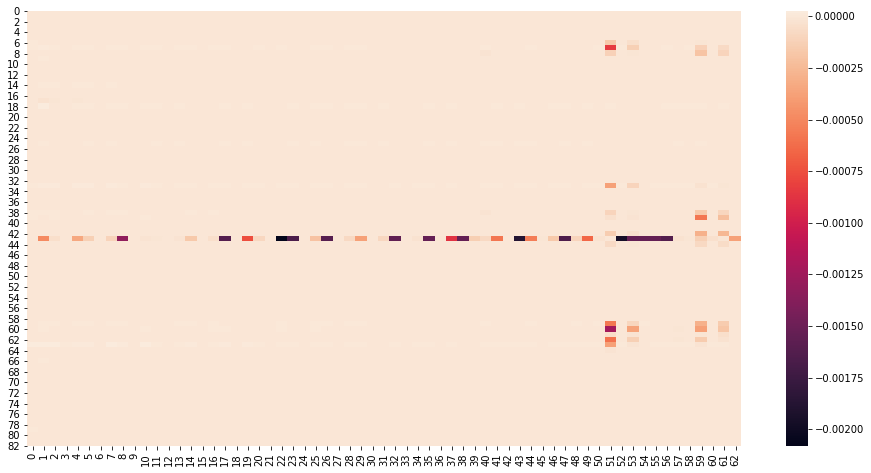

In [63]:
plt.figure(figsize=(16,8))
sns.heatmap(new_shap_values[0])

In [58]:
y.shape

(84, 1113)

In [155]:
shap_values[13].shape

(84, 1113)

In [122]:
y = shap_values[13]

In [123]:
sample_test = []
feature_array = []
length = 233
for x in range(0,84):
    print("Dimensions #",x+1)
    print(y[x])
    print(y[x].shape[0])
    new_anomaly = y[x][:length]
    print(new_anomaly.shape[0])
    val_pad = 233 - new_anomaly.shape[0]
    if val_pad != 0:
        new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
    feature_array.append(new_anomaly)
sample_test.append(feature_array)
print("#####################################################")
sample_test = numpy.array(sample_test)

Dimensions # 1
[3.09244472e-10 3.27748446e-09 3.45456746e-08 ...            nan
            nan            nan]
1113
233
Dimensions # 2
[-7.70336740e-07 -4.56938101e-07 -3.79356997e-07 ...             nan
             nan             nan]
1113
233
Dimensions # 3
[-3.31858256e-16 -3.45717344e-13  0.00000000e+00 ...             nan
             nan             nan]
1113
233
Dimensions # 4
[-2.07740793e-16  4.36829977e-13  3.50082809e-13 ...             nan
             nan             nan]
1113
233
Dimensions # 5
[-7.69137454e-06 -4.89961066e-06 -7.33593292e-06 ...             nan
             nan             nan]
1113
233
Dimensions # 6
[ 2.82254917e-08 -3.40485055e-08  9.69797630e-09 ...             nan
             nan             nan]
1113
233
Dimensions # 7
[-4.91432397e-05 -3.37730537e-07  3.72131717e-07 ...             nan
             nan             nan]
1113
233
Dimensions # 8
[-1.12285018e-05 -1.09983014e-05 -6.59797605e-06 ...             nan
             nan             nan]

In [124]:
sample_test.shape

(1, 84, 233)

In [125]:
x_axis_labels = features_order_in_data

In [126]:
x_axis_labels

['Read Cache Hits - VCC (%)',
 'Overall Back-end Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send Data Rate (MiB/s)',
 'Write Data Rate (MiB/s)',
 'Read Cache Hits - VC (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port Receive Data Rate (MiB/s)',
 'Overall Response Time (ms/op)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Total Cache Hits - VCC (%)',
 'Total Cache Hits - VC (%)',
 'Port to Host Send I/O Rate (ops/s)',
 'Write Cache Hits - VCC (%)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send Data Rate (MiB

In [128]:
sample_test.shape

(1, 84, 233)

In [129]:
sample_test[0].shape

(84, 233)

In [138]:
sample_test[0].T.shape

(233, 84)

In [136]:
test = pd.DataFrame(sample_test[0].T)

In [150]:
test.head()

0             1             2             3             4   \
0  3.092445e-10 -7.703367e-07 -3.318583e-16 -2.077408e-16 -7.691375e-06   
1  3.277484e-09 -4.569381e-07 -3.457173e-13  4.368300e-13 -4.899611e-06   
2  3.454567e-08 -3.793570e-07  0.000000e+00  3.500828e-13 -7.335933e-06   
3  5.025707e-09 -1.447206e-07 -3.443244e-15  9.038572e-14 -1.940981e-06   
4  4.981583e-09 -2.614719e-08  0.000000e+00  0.000000e+00 -5.348987e-07   

             5             6         7             8             9   ...  \
0  2.822549e-08 -4.914324e-05 -0.000011  5.046198e-08 -4.506244e-06  ...   
1 -3.404851e-08 -3.377305e-07 -0.000011 -2.120783e-08  1.204104e-06  ...   
2  9.697976e-09  3.721317e-07 -0.000007  2.093845e-07  1.137877e-07  ...   
3  1.149212e-08  2.927293e-09 -0.000004  1.044564e-08  2.199945e-08  ...   
4 -5.220469e-08 -1.120328e-08  0.000001  6.780925e-08  2.374060e-07  ...   

             74            75            76            77            78  \
0  1.140556e-09  2.630825e-09 -4.701627e-15 -4.100015e-07 -6.779077e-12   
1 -3.246602e-08 -9.462738e-08 -3.845030e-13 -2.447896e-08 -1.818679e-09   
2  7.028628e-08  7.621514e-08  0.000000e+00  4.465845e-10 -1.383532e-10   
3 -5.586717e-08 -6.178895e-08  0.000000e+00  1.533736e-10 -3.178713e-11   
4  7.793455e-08  6.904710e-08  0.000000e+00  1.500636e-10 -7.555927e-10   

             79            80            81            82            83  
0 -1.499197e-05 -6.338756e-07  2.195993e-07  1.436947e-08  1.111220e-08  
1 -7.698190e-07  3.345224e-10  1.914464e-08 -4.246456e-08  2.455824e-09  
2 -1.972739e-06  4.499661e-08  2.014652e-07 -1.369338e-06  1.260929e-08  
3 -1.834127e-08  3.222038e-09  1.470340e-08 -8.473020e-08  1.490198e-09  
4  1.138088e-09  6.660166e-09  3.645209e-08 -1.742912e-07  1.803764e-09  

[5 rows x 84 columns]

In [140]:
sample_test[0][0].shape

(233,)

In [142]:
test

0             1             2             3             4   \
0    3.092445e-10 -7.703367e-07 -3.318583e-16 -2.077408e-16 -7.691375e-06   
1    3.277484e-09 -4.569381e-07 -3.457173e-13  4.368300e-13 -4.899611e-06   
2    3.454567e-08 -3.793570e-07  0.000000e+00  3.500828e-13 -7.335933e-06   
3    5.025707e-09 -1.447206e-07 -3.443244e-15  9.038572e-14 -1.940981e-06   
4    4.981583e-09 -2.614719e-08  0.000000e+00  0.000000e+00 -5.348987e-07   
..            ...           ...           ...           ...           ...   
228  4.914406e-07  1.411054e-06  0.000000e+00  0.000000e+00  2.972227e-06   
229  4.641589e-08  1.142718e-07  0.000000e+00  0.000000e+00  2.770896e-07   
230  7.456317e-08  1.885010e-07  0.000000e+00  0.000000e+00  4.241569e-07   
231  6.517543e-07  2.047600e-06  1.421335e-12  0.000000e+00  3.824560e-06   
232  6.754687e-07  1.231182e-06  0.000000e+00  0.000000e+00  4.003874e-06   

               5             6         7             8             9   ...  \
0    2.822549e-08 -4.914324e-05 -0.000011  5.046198e-08 -4.506244e-06  ...   
1   -3.404851e-08 -3.377305e-07 -0.000011 -2.120783e-08  1.204104e-06  ...   
2    9.697976e-09  3.721317e-07 -0.000007  2.093845e-07  1.137877e-07  ...   
3    1.149212e-08  2.927293e-09 -0.000004  1.044564e-08  2.199945e-08  ...   
4   -5.220469e-08 -1.120328e-08  0.000001  6.780925e-08  2.374060e-07  ...   
..            ...           ...       ...           ...           ...  ...   
228 -8.683124e-06 -4.770967e-05 -0.000093 -1.126214e-05  2.791036e-08  ...   
229 -6.275641e-07 -4.362671e-06 -0.000008 -1.102399e-06  2.405340e-09  ...   
230 -1.329606e-06 -1.036711e-05 -0.000017 -2.481380e-06  9.149610e-08  ...   
231 -1.224216e-05 -6.686007e-05 -0.000115 -2.126817e-05  1.795256e-07  ...   
232 -4.742824e-06 -5.809210e-05 -0.000107 -1.900835e-05  3.289783e-08  ...   

               74            75            76            77            78  \
0    1.140556e-09  2.630825e-09 -4.701627e-15 -4.100015e-07 -6.779077e-12   
1   -3.246602e-08 -9.462738e-08 -3.845030e-13 -2.447896e-08 -1.818679e-09   
2    7.028628e-08  7.621514e-08  0.000000e+00  4.465845e-10 -1.383532e-10   
3   -5.586717e-08 -6.178895e-08  0.000000e+00  1.533736e-10 -3.178713e-11   
4    7.793455e-08  6.904710e-08  0.000000e+00  1.500636e-10 -7.555927e-10   
..            ...           ...           ...           ...           ...   
228 -2.353391e-12 -1.415849e-10  0.000000e+00  5.558381e-07  7.234602e-09   
229 -4.820377e-12 -2.822951e-10  0.000000e+00  5.060984e-08 -1.530164e-09   
230 -4.771548e-12 -2.172178e-10  0.000000e+00  8.747523e-08 -9.402775e-12   
231 -4.812460e-12 -3.042118e-10 -9.340580e-16  6.880294e-07 -2.298161e-09   
232 -4.447323e-12 -2.825798e-10  0.000000e+00  7.676649e-07 -8.876972e-10   

               79            80            81            82            83  
0   -1.499197e-05 -6.338756e-07  2.195993e-07  1.436947e-08  1.111220e-08  
1   -7.698190e-07  3.345224e-10  1.914464e-08 -4.246456e-08  2.455824e-09  
2   -1.972739e-06  4.499661e-08  2.014652e-07 -1.369338e-06  1.260929e-08  
3   -1.834127e-08  3.222038e-09  1.470340e-08 -8.473020e-08  1.490198e-09  
4    1.138088e-09  6.660166e-09  3.645209e-08 -1.742912e-07  1.803764e-09  
..            ...           ...           ...           ...           ...  
228  2.349473e-05  7.768688e-06  2.193904e-05  2.784185e-06  7.499145e-07  
229  2.130998e-06  7.040343e-07  1.990071e-06  2.526636e-07  5.721442e-08  
230  3.269106e-06  1.080074e-06  3.051966e-06  3.872705e-07  9.385639e-08  
231  3.060746e-05  1.011402e-05  2.857073e-05  3.629857e-06  1.149159e-06  
232  2.967611e-05  9.807821e-06  2.769827e-05  3.521782e-06  5.463371e-07  

[233 rows x 84 columns]

In [260]:
sample_test[0].shape

(84, 233)

In [169]:
das = sample_test[0]

In [171]:
das[0].shape

(233,)

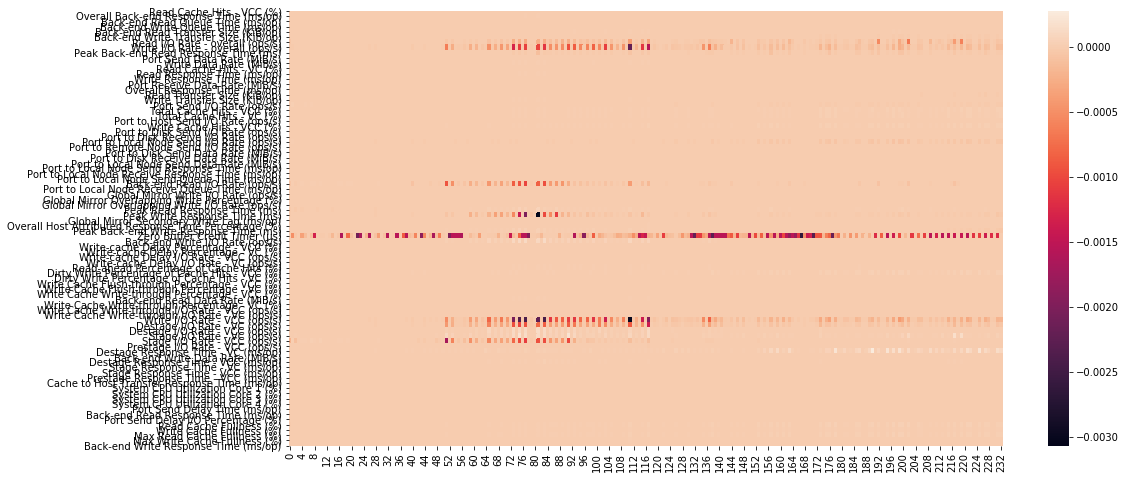

In [208]:
plt.figure(figsize=(16,8))
sns.heatmap(sample_test[0],yticklabels=x_axis_labels)
plt.savefig("test-heatmap.png")
plt.show()

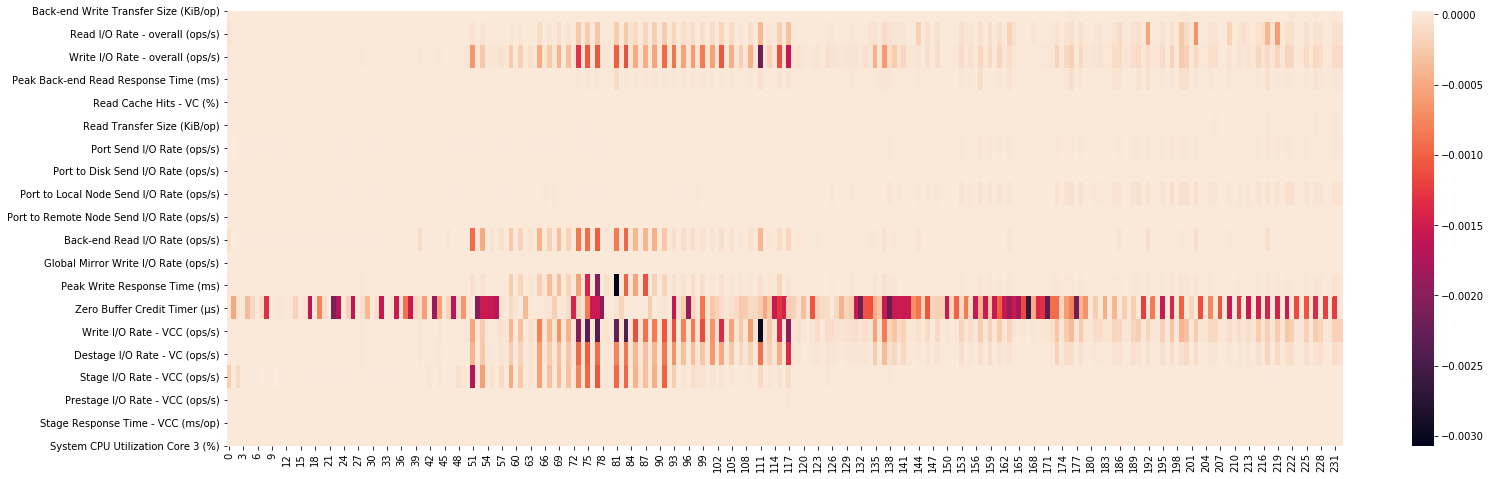

In [335]:
plt.figure(figsize=(25,8))
sns.heatmap(maybe,yticklabels=final_final_final)
plt.savefig("test-heatmap.png")
plt.show()

In [303]:
cmap_test = sns.light_palette("#00008B",as_cmap=True)

In [320]:
print("hello world")

hello world


In [311]:
cmap_test_2 = sns.dark_palette("#4169E1",as_cmap=True)

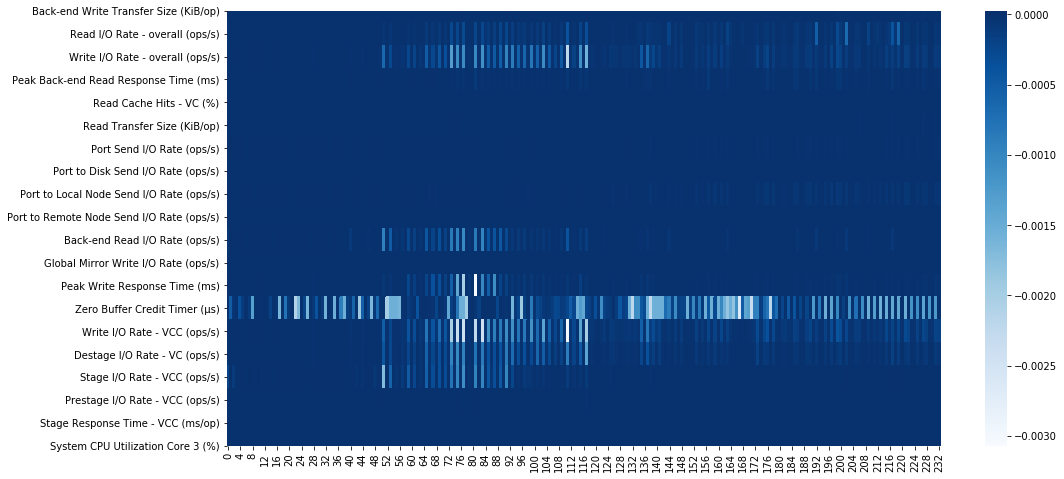

In [309]:
plt.figure(figsize=(16,8))
sns.heatmap(maybe,yticklabels=final_final_final,cmap="Blues")
plt.savefig("test-heatmap_blue.png")
plt.show()

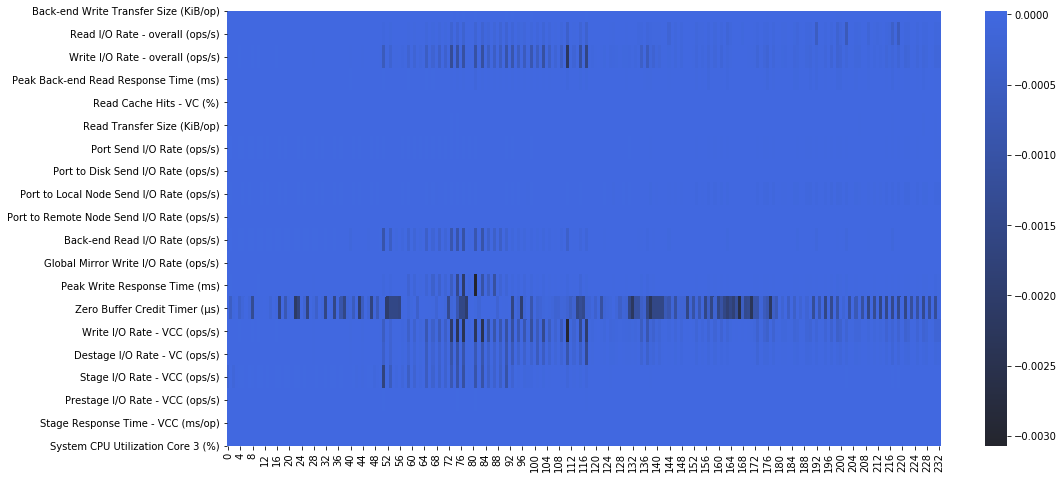

In [312]:
plt.figure(figsize=(16,8))
sns.heatmap(maybe,yticklabels=final_final_final,cmap=cmap_test_2)
plt.savefig("test-heatmap_blue.png")
plt.show()

In [313]:
cmap = sns.cm.rocket_r

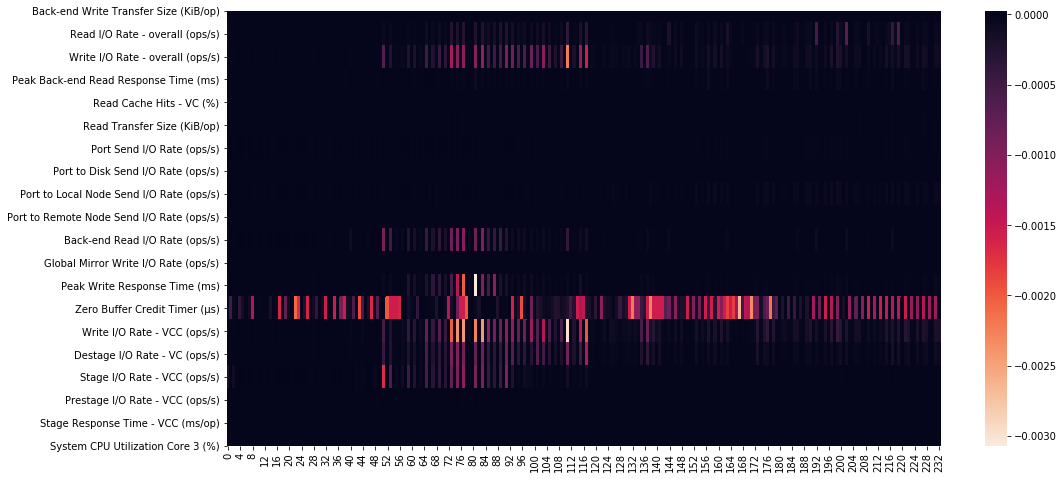

In [315]:
plt.figure(figsize=(16,8))
sns.heatmap(maybe,yticklabels=final_final_final,cmap=cmap)
plt.savefig("test-heatmap_blue.png")
plt.show()

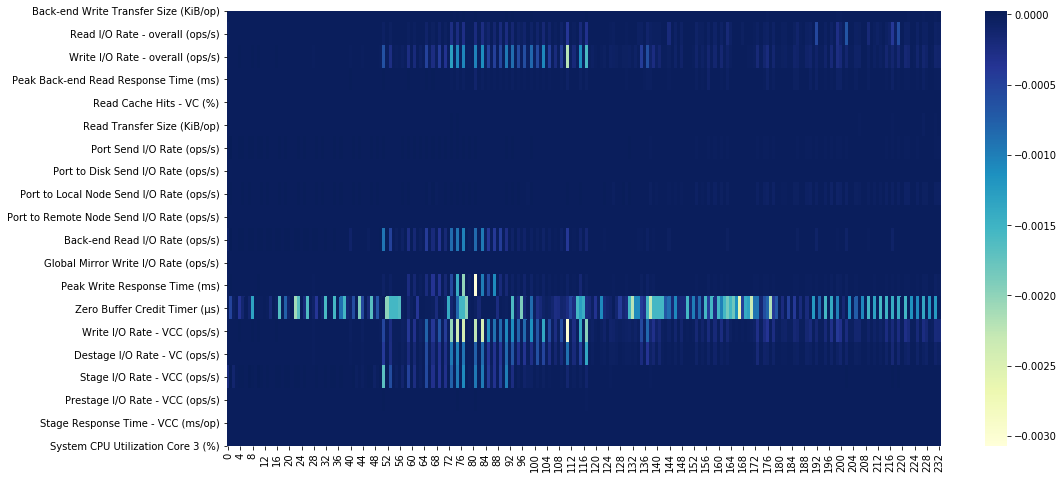

In [316]:
plt.figure(figsize=(16,8))
sns.heatmap(maybe,yticklabels=final_final_final,cmap="YlGnBu")
plt.savefig("test-heatmap_blue.png")
plt.show()

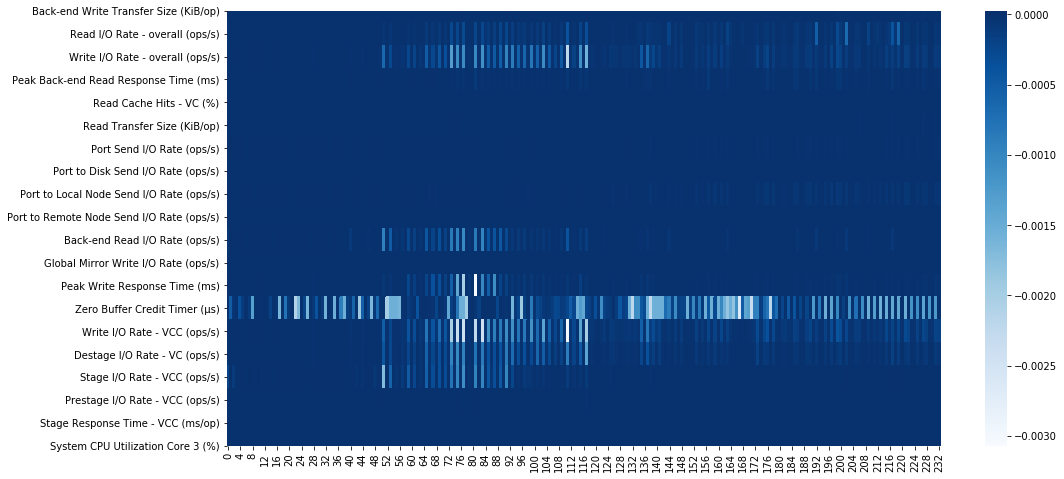

In [317]:
plt.figure(figsize=(16,8))
sns.heatmap(maybe,yticklabels=final_final_final,cmap="Blues")
plt.savefig("test-heatmap_blue.png")
plt.show()

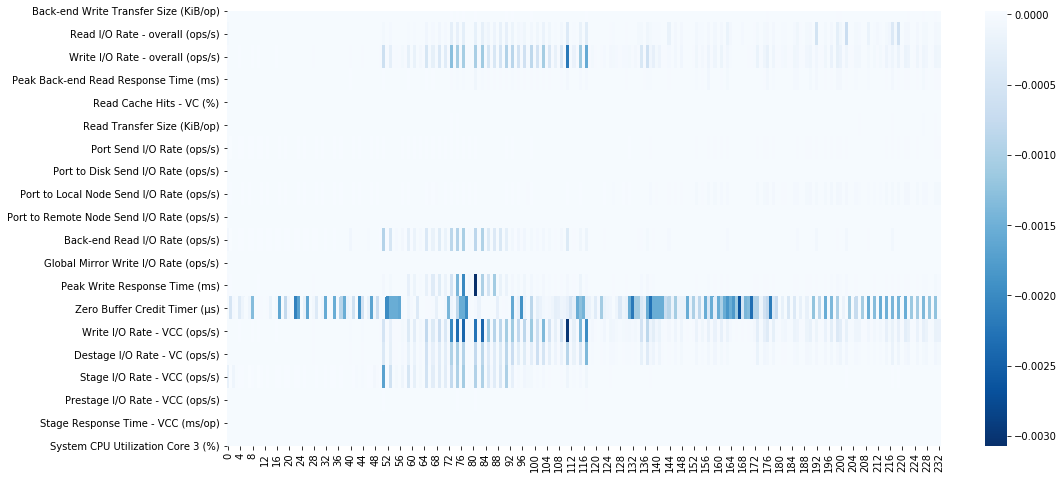

In [318]:
plt.figure(figsize=(16,8))
sns.heatmap(maybe,yticklabels=final_final_final,cmap="Blues_r")
plt.savefig("test-heatmap_blue.png")
plt.show()

In [210]:
to_remove = top_20['col_name'].tolist()
to_remove

['Zero Buffer Credit Timer (µs)',
 'Write I/O Rate - VCC (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Destage I/O Rate - VC (ops/s)',
 'Peak Write Response Time (ms)',
 'Stage I/O Rate - VCC (ops/s)',
 'Back-end Read I/O Rate (ops/s)',
 'Read I/O Rate - overall (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send I/O Rate (ops/s)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read Transfer Size (KiB/op)',
 'Prestage I/O Rate - VCC (ops/s)',
 'System CPU Utilization Core 3 (%)',
 'Stage Response Time - VCC (ms/op)',
 'Read Cache Hits - VC (%)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Global Mirror Write I/O Rate (ops/s)']

In [278]:
features_x_sort = []
for i in to_remove:
    print(x_axis_labels.index(i))
    to_append = (x_axis_labels.index(i),i)
    features_x_sort.append(to_append)

43
59
7
60
39
63
33
6
25
8
18
5
16
64
74
69
11
26
23
35


In [283]:
type(features_x_sort[0])

tuple

In [284]:
sorted_by_second = sorted(features_x_sort, key=lambda tup: tup[0])

In [292]:
final_final_final = []
for i in sorted_by_second:
    print(i[1])
    final_final_final.append(i[1])

Back-end Write Transfer Size (KiB/op)
Read I/O Rate - overall (ops/s)
Write I/O Rate - overall (ops/s)
Peak Back-end Read Response Time (ms)
Read Cache Hits - VC (%)
Read Transfer Size (KiB/op)
Port Send I/O Rate (ops/s)
Port to Disk Send I/O Rate (ops/s)
Port to Local Node Send I/O Rate (ops/s)
Port to Remote Node Send I/O Rate (ops/s)
Back-end Read I/O Rate (ops/s)
Global Mirror Write I/O Rate (ops/s)
Peak Write Response Time (ms)
Zero Buffer Credit Timer (µs)
Write I/O Rate - VCC (ops/s)
Destage I/O Rate - VC (ops/s)
Stage I/O Rate - VCC (ops/s)
Prestage I/O Rate - VCC (ops/s)
Stage Response Time - VCC (ms/op)
System CPU Utilization Core 3 (%)


In [293]:
final_final_final

['Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Read Cache Hits - VC (%)',
 'Read Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Back-end Read I/O Rate (ops/s)',
 'Global Mirror Write I/O Rate (ops/s)',
 'Peak Write Response Time (ms)',
 'Zero Buffer Credit Timer (µs)',
 'Write I/O Rate - VCC (ops/s)',
 'Destage I/O Rate - VC (ops/s)',
 'Stage I/O Rate - VCC (ops/s)',
 'Prestage I/O Rate - VCC (ops/s)',
 'Stage Response Time - VCC (ms/op)',
 'System CPU Utilization Core 3 (%)']

In [259]:
really_remove

{'Back-end Read Data Rate (MiB/s)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Data Rate (MiB/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Write Response Time (ms/op)',
 'Cache to Host Transfer Response Time (ms/op)',
 'Destage I/O Rate - VCC (ops/s)',
 'Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Dirty Write Percentage of Cache Hits - VC (%)',
 'Dirty Write Percentage of Cache Hits - VCC (%)',
 'Global Mirror Overlapping Write I/O Rate (ops/s)',
 'Global Mirror Overlapping Write Percentage (%)',
 'Global Mirror Secondary Write Lag (ms/op)',
 'Max Read Cache Fullness (%)',
 'Max Write Cache Fullness (%)',
 'Overall Back-end Response Time (ms/op)',
 'Overall Host Attributed Response Time Percentage (%)',
 'Overall Response Time (ms/op)',
 'Peak Back-end Write Response Time (ms)',
 'Peak Read Response Time (ms)',
 'Por

In [267]:
really_remove_indices = []
for i in really_remove:
    print(x_axis_labels.index(i))
    really_remove_indices.append(x_axis_labels.index(i))

24
22
32
52
77
70
50
10
27
61
57
68
40
4
17
46
0
49
41
2
48
54
30
34
42
78
72
20
13
51
38
44
56
71
14
67
36
45
3
53
83
31
21
66
79
76
65
1
19
37
82
55
62
9
75
81
28
12
47
73
29
80
58
15


In [268]:
really_remove_indices

[24,
 22,
 32,
 52,
 77,
 70,
 50,
 10,
 27,
 61,
 57,
 68,
 40,
 4,
 17,
 46,
 0,
 49,
 41,
 2,
 48,
 54,
 30,
 34,
 42,
 78,
 72,
 20,
 13,
 51,
 38,
 44,
 56,
 71,
 14,
 67,
 36,
 45,
 3,
 53,
 83,
 31,
 21,
 66,
 79,
 76,
 65,
 1,
 19,
 37,
 82,
 55,
 62,
 9,
 75,
 81,
 28,
 12,
 47,
 73,
 29,
 80,
 58,
 15]

In [261]:
test_test = sample_test[0]

In [262]:
test_test.shape

(84, 233)

In [269]:
maybe = numpy.delete(test_test, (really_remove_indices), axis=0)

In [270]:
maybe.shape

(20, 233)

In [213]:
x_axis_labels

['Read Cache Hits - VCC (%)',
 'Overall Back-end Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send Data Rate (MiB/s)',
 'Write Data Rate (MiB/s)',
 'Read Cache Hits - VC (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port Receive Data Rate (MiB/s)',
 'Overall Response Time (ms/op)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Total Cache Hits - VCC (%)',
 'Total Cache Hits - VC (%)',
 'Port to Host Send I/O Rate (ops/s)',
 'Write Cache Hits - VCC (%)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send Data Rate (MiB

In [216]:
st = set(to_remove)

In [219]:
to_remov_indices

[5, 6, 7, 8, 11, 16, 18, 23, 25, 26, 33, 35, 39, 43, 59, 60, 63, 64, 69, 74]

In [255]:
set_a = set(to_remove)

In [256]:
set_a

{'Back-end Read I/O Rate (ops/s)',
 'Back-end Write Transfer Size (KiB/op)',
 'Destage I/O Rate - VC (ops/s)',
 'Global Mirror Write I/O Rate (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Peak Write Response Time (ms)',
 'Port Send I/O Rate (ops/s)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Prestage I/O Rate - VCC (ops/s)',
 'Read Cache Hits - VC (%)',
 'Read I/O Rate - overall (ops/s)',
 'Read Transfer Size (KiB/op)',
 'Stage I/O Rate - VCC (ops/s)',
 'Stage Response Time - VCC (ms/op)',
 'System CPU Utilization Core 3 (%)',
 'Write I/O Rate - VCC (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Zero Buffer Credit Timer (µs)'}

In [252]:
set_x_axis_labels = set(x_axis_labels)

In [253]:
set_x_axis_labels

{'Back-end Read Data Rate (MiB/s)',
 'Back-end Read I/O Rate (ops/s)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Data Rate (MiB/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Write Response Time (ms/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Cache to Host Transfer Response Time (ms/op)',
 'Destage I/O Rate - VC (ops/s)',
 'Destage I/O Rate - VCC (ops/s)',
 'Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Dirty Write Percentage of Cache Hits - VC (%)',
 'Dirty Write Percentage of Cache Hits - VCC (%)',
 'Global Mirror Overlapping Write I/O Rate (ops/s)',
 'Global Mirror Overlapping Write Percentage (%)',
 'Global Mirror Secondary Write Lag (ms/op)',
 'Global Mirror Write I/O Rate (ops/s)',
 'Max Read Cache Fullness (%)',
 'Max Write Cache Fullness (%)',
 'Overall Back-end Response Time (ms/op)',
 'Overall Host Attri

In [257]:
really_remove = set_x_axis_labels - set_a
really_remove

{'Back-end Read Data Rate (MiB/s)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Data Rate (MiB/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Write Response Time (ms/op)',
 'Cache to Host Transfer Response Time (ms/op)',
 'Destage I/O Rate - VCC (ops/s)',
 'Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Dirty Write Percentage of Cache Hits - VC (%)',
 'Dirty Write Percentage of Cache Hits - VCC (%)',
 'Global Mirror Overlapping Write I/O Rate (ops/s)',
 'Global Mirror Overlapping Write Percentage (%)',
 'Global Mirror Secondary Write Lag (ms/op)',
 'Max Read Cache Fullness (%)',
 'Max Write Cache Fullness (%)',
 'Overall Back-end Response Time (ms/op)',
 'Overall Host Attributed Response Time Percentage (%)',
 'Overall Response Time (ms/op)',
 'Peak Back-end Write Response Time (ms)',
 'Peak Read Response Time (ms)',
 'Por

In [258]:
len(really_remove)

64

In [248]:

for i in x_axis_labels:
    print(x_axis_labels.index(i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


In [242]:
test_test = sample_test[0]

In [243]:
test_test.shape

(84, 233)

In [244]:
sample_test[0].shape

(84, 233)

In [245]:
aua = numpy.delete(test_test, (to_remov_indices), axis=0)

In [246]:
aua.shape

(64, 233)

In [234]:
numpy.delete(test_test, (5), axis=0)
numpy.delete(test_test, (6), axis=0)
numpy.delete(test_test, (7), axis=0)
numpy.delete(test_test, (8), axis=0)
numpy.delete(test_test, (11), axis=0)
numpy.delete(test_test, (16), axis=0)
numpy.delete(test_test, (18), axis=0)
numpy.delete(test_test, (23), axis=0)
numpy.delete(test_test, (25), axis=0)
numpy.delete(test_test, (26), axis=0)
numpy.delete(test_test, (33), axis=0)
numpy.delete(test_test, (35), axis=0)
numpy.delete(test_test, (39), axis=0)
numpy.delete(test_test, (43), axis=0)
numpy.delete(test_test, (59), axis=0)
numpy.delete(test_test, (60), axis=0)
numpy.delete(test_test, (63), axis=0)
numpy.delete(test_test, (64), axis=0)
numpy.delete(test_test, (69), axis=0)
numpy.delete(test_test, (74), axis=0)

array([[ 3.09244472e-10,  3.27748446e-09,  3.45456746e-08, ...,
         7.45631725e-08,  6.51754252e-07,  6.75468651e-07],
       [-7.70336740e-07, -4.56938101e-07, -3.79356997e-07, ...,
         1.88500997e-07,  2.04759984e-06,  1.23118234e-06],
       [-3.31858256e-16, -3.45717344e-13,  0.00000000e+00, ...,
         0.00000000e+00,  1.42133545e-12,  0.00000000e+00],
       ...,
       [ 2.19599302e-07,  1.91446437e-08,  2.01465205e-07, ...,
         3.05196566e-06,  2.85707315e-05,  2.76982706e-05],
       [ 1.43694704e-08, -4.24645591e-08, -1.36933755e-06, ...,
         3.87270543e-07,  3.62985656e-06,  3.52178186e-06],
       [ 1.11121995e-08,  2.45582382e-09,  1.26092943e-08, ...,
         9.38563913e-08,  1.14915919e-06,  5.46337148e-07]])

In [236]:
test_test.shape

(84, 233)

In [218]:
to_remov_indices = [i for i, e in enumerate(x_axis_labels) if e in st]

In [211]:
haystack = ['a', 'b', 'c', 'V', 'd', 'e', 'X', 'f', 'V', 'g', 'h']
needles = ['V', 'W', 'X', 'Y', 'Z']
st = set(needles)
print([i for i, e in enumerate(haystack) if e in st])
[3, 6, 8]

[3, 6, 8]


[3, 6, 8]

In [153]:
x_axis_labels[0]

'Read Cache Hits - VCC (%)'

In [149]:
sample_test[0][1].shape

(233,)

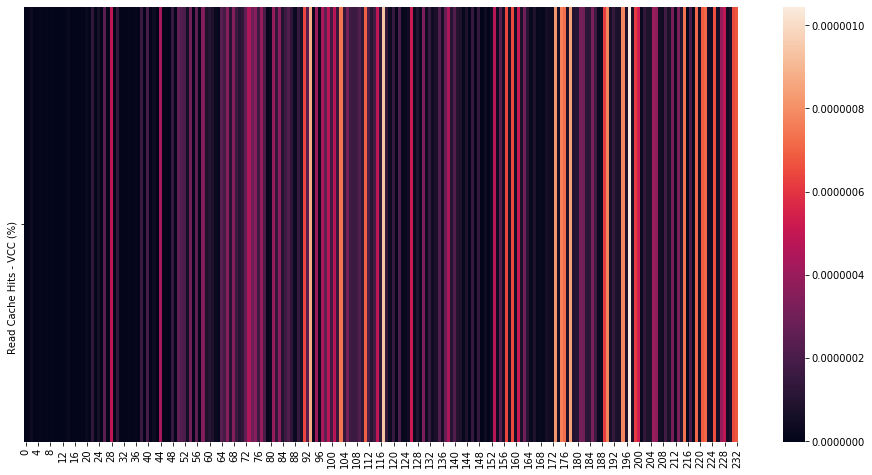

In [147]:
plt.figure(figsize=(16,8))
sns.heatmap(sample_test[0][:1],yticklabels=x_axis_labels[:1])
plt.show()

In [107]:
shap_values.shape

(14, 84, 1113)

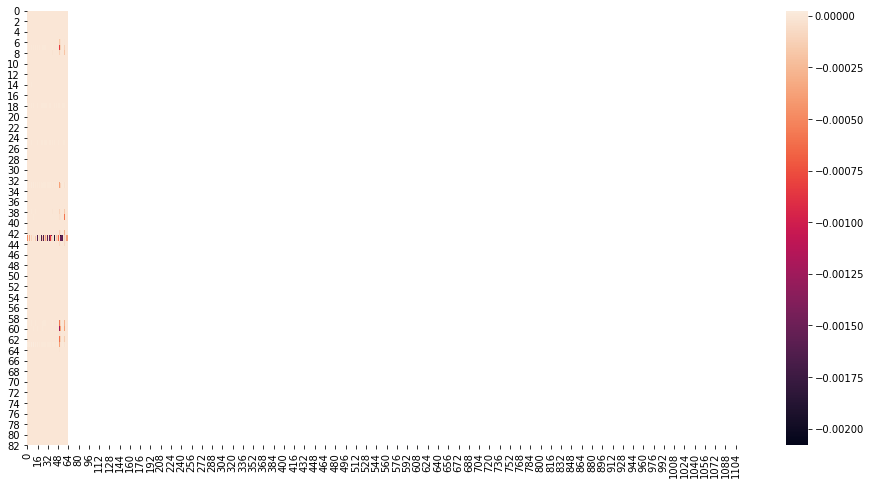

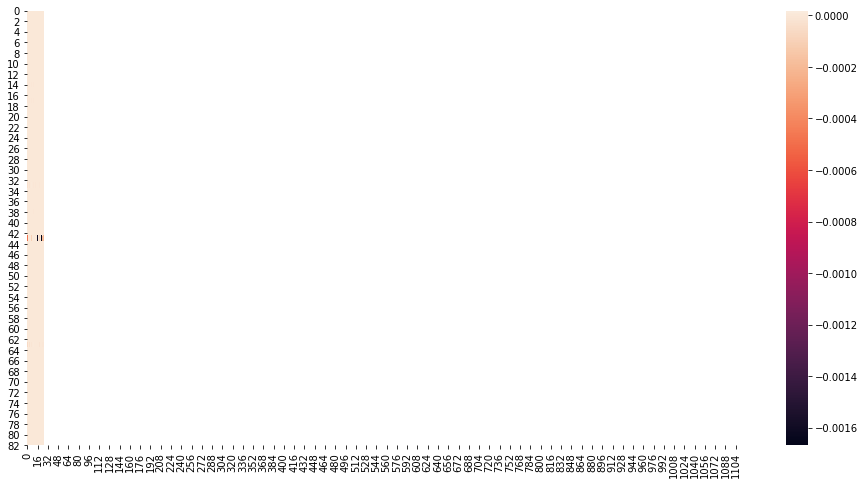

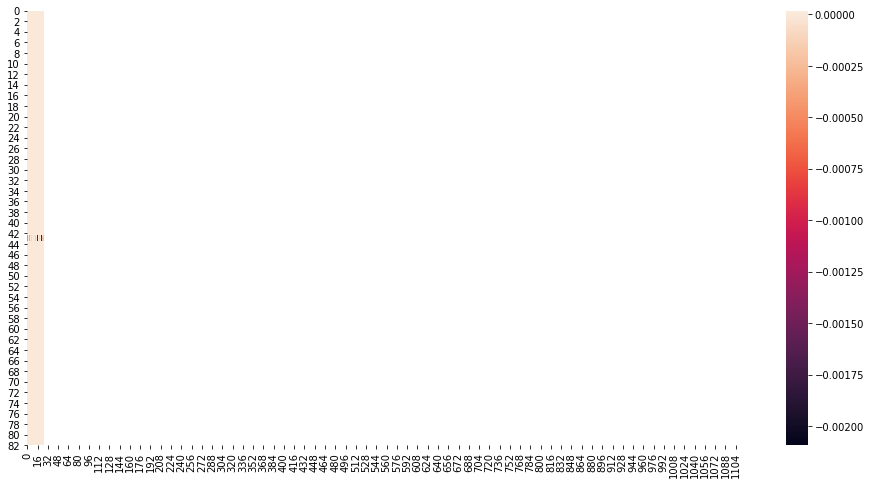

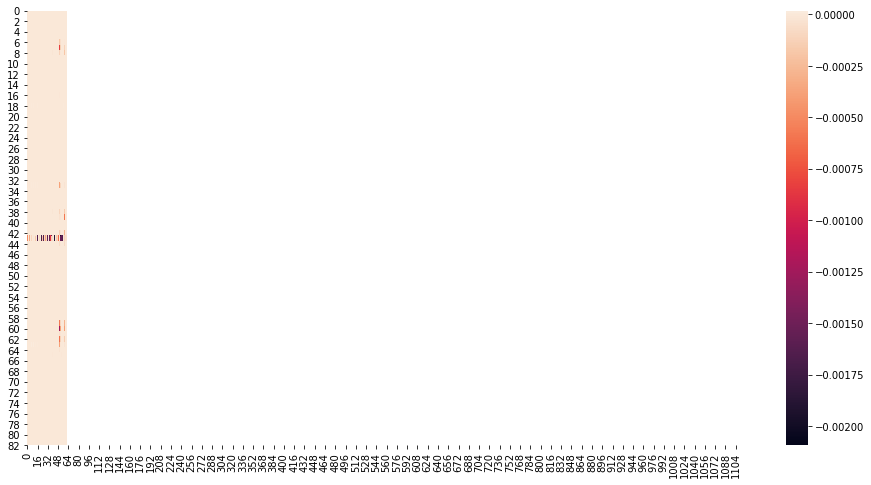

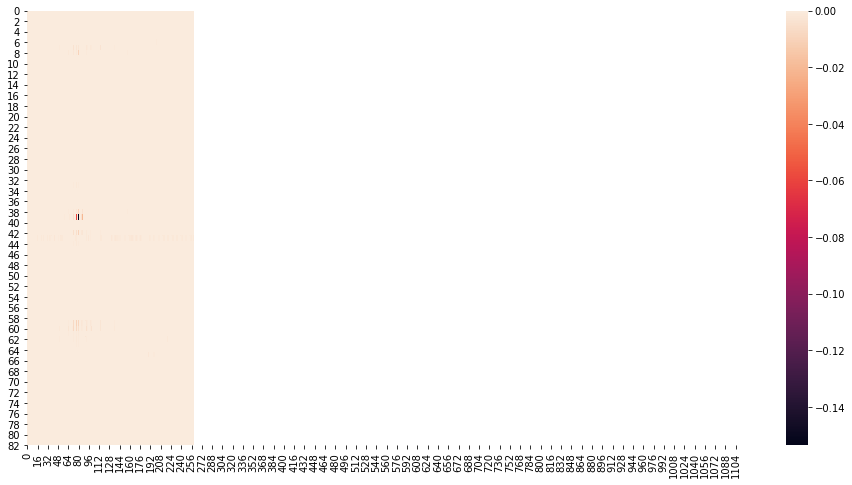

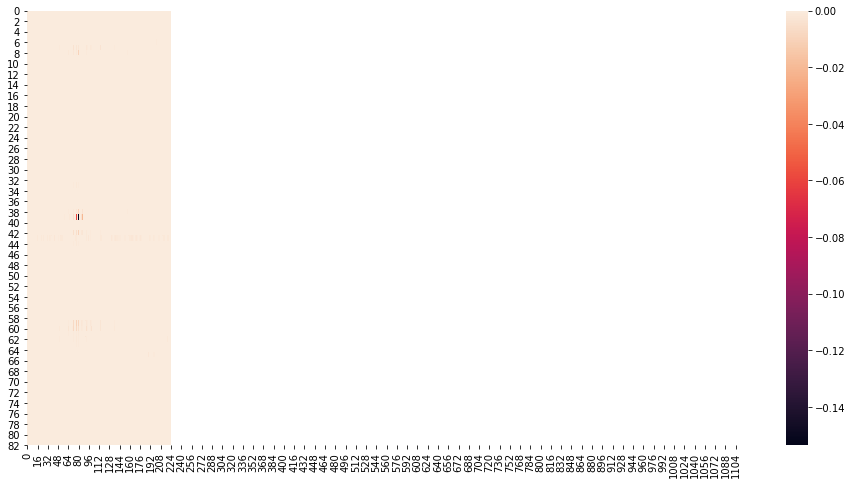

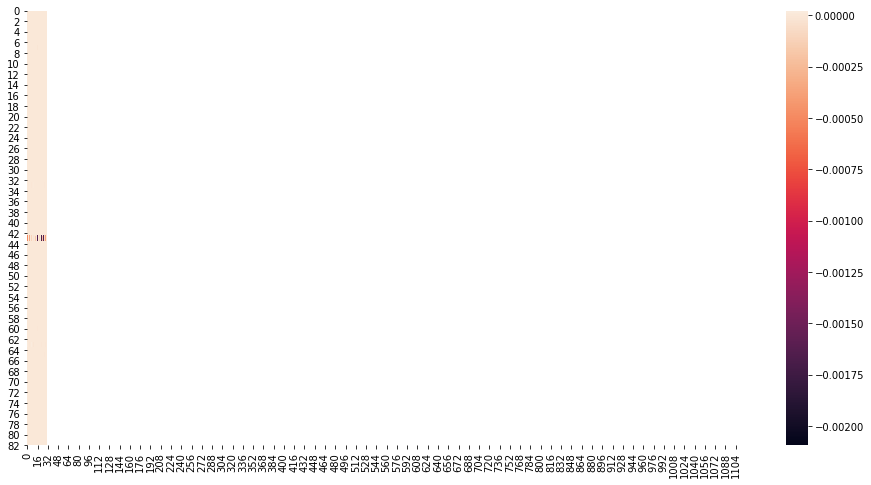

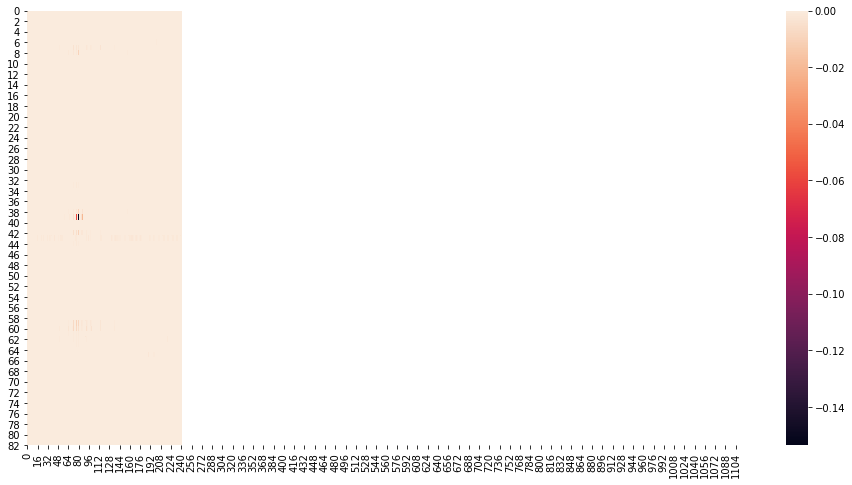

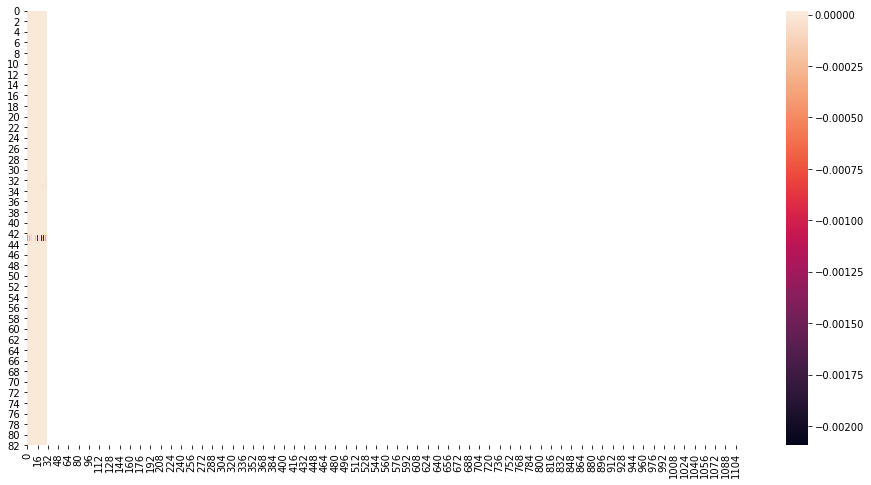

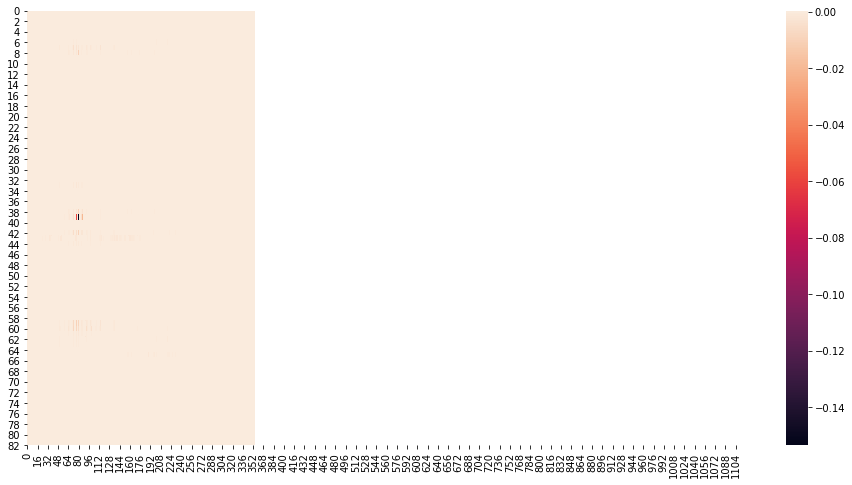

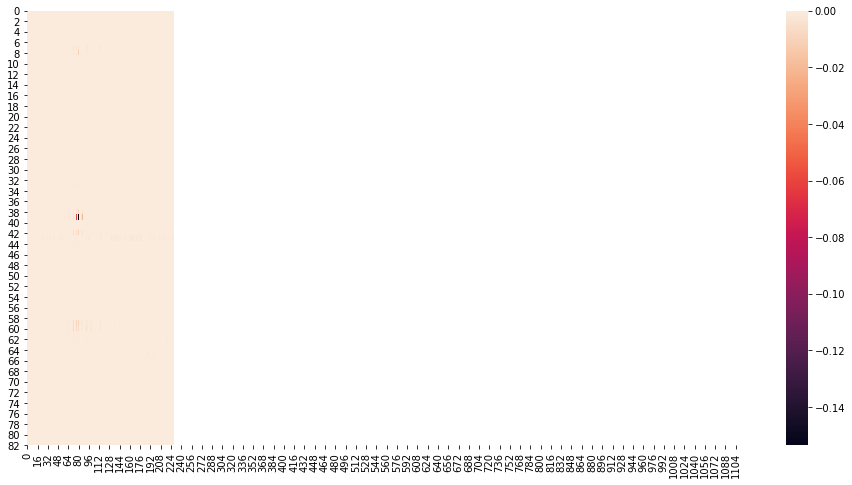

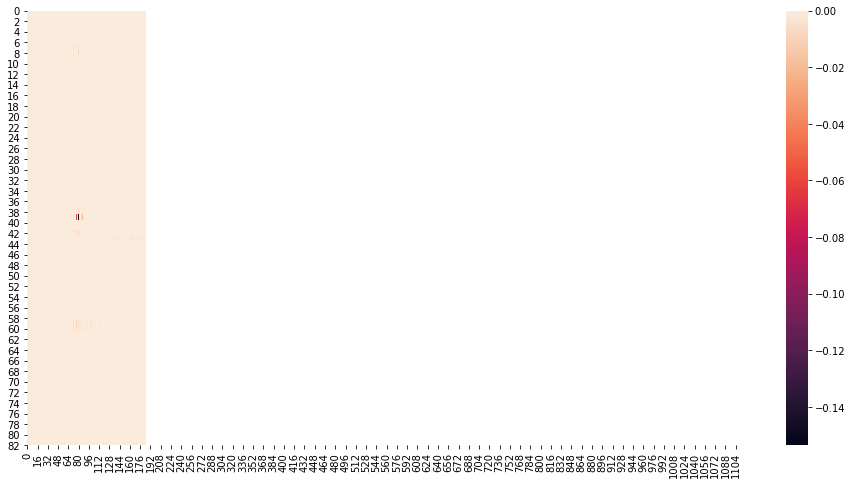

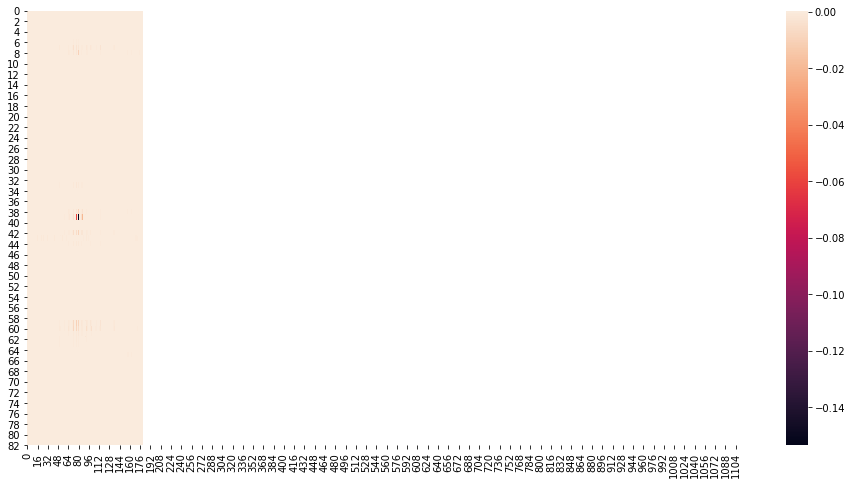

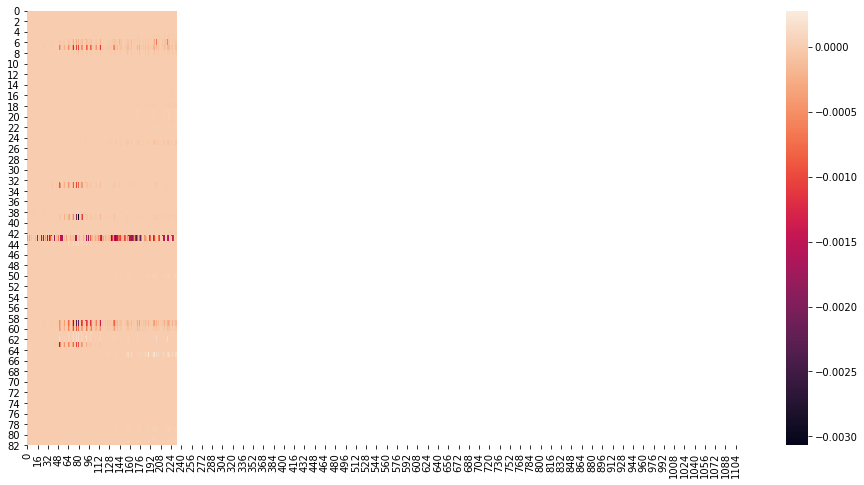

In [33]:
for i in shap_values:
    plt.figure(figsize=(16,8))
    sns.heatmap(i)
    plt.show()

In [158]:
shap_values[13].shape

(84, 1113)

In [159]:
dataset[13].shape

(84, 1113)

# Feature Explanations

In [160]:
shap_values_allTimesteps = numpy.nanmean(shap_values, axis=2)
print(shap_values_allTimesteps.shape)
print(shap_values_allTimesteps)

(14, 84)
[[-1.19440848e-07 -1.84696628e-08  8.63299102e-15 ... -2.56562611e-07
  -5.73543816e-08 -2.21437904e-08]
 [-2.71714982e-09  1.57643064e-08 -1.51117198e-14 ... -1.03079626e-08
   1.13150028e-08 -8.36428539e-10]
 [-4.27825604e-09  8.40104699e-10 -2.27244584e-14 ... -1.07103095e-08
   4.94218262e-09 -6.92870214e-10]
 ...
 [-3.01619177e-06 -2.65354690e-07 -1.14582585e-14 ... -4.14782060e-06
  -1.30908202e-06 -5.16259436e-07]
 [-2.98639556e-06 -2.71574659e-07 -1.11728008e-14 ... -4.16791974e-06
  -1.32835862e-06 -5.30620882e-07]
 [ 1.90829133e-07  6.98843498e-07  7.49801870e-14 ...  6.56019162e-06
   9.23561276e-07  4.74506444e-07]]


In [161]:
samples_allTimesteps = numpy.nanmean(dataset, axis=2)
print(samples_allTimesteps.shape)
print(samples_allTimesteps)

(14, 84)
[[4.43837874e-06 2.02746612e-06 5.64428698e-11 ... 7.24238612e-06
  5.21704534e-06 2.53336921e-06]
 [8.40688025e-06 4.10895905e-07 2.82826805e-11 ... 8.02088784e-06
  3.79630273e-06 1.27899910e-06]
 [3.90977239e-06 1.21713005e-06 0.00000000e+00 ... 7.73119111e-06
  5.24294254e-06 1.57069420e-06]
 ...
 [5.14678938e-06 1.11017634e-06 3.70302252e-11 ... 7.10035048e-06
  6.83892368e-06 3.11496266e-06]
 [6.78659417e-06 5.27778798e-07 0.00000000e+00 ... 6.67272752e-06
  3.14177627e-06 1.36144642e-06]
 [3.54478039e-03 6.45441490e-04 1.06261875e-08 ... 4.09348085e-03
  2.06476360e-03 8.43438411e-04]]


In [163]:
shap_values_allTimesteps[13].shape

(84,)

In [166]:
shap_values_allTimesteps[13].reshape(1,84).shape

(1, 84)

In [167]:
samples_allTimesteps[13].shape

(84,)

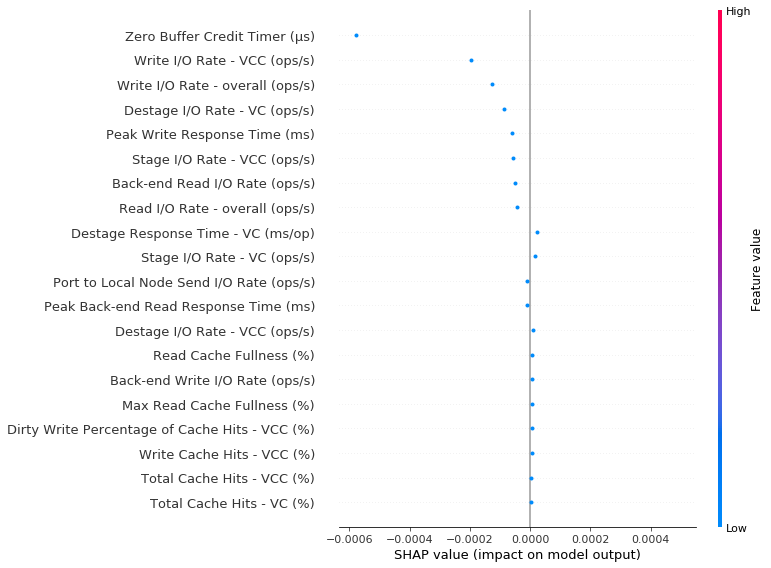

In [168]:
shap.summary_plot(shap_values_allTimesteps[13].reshape(1,84), samples_allTimesteps[13].reshape(1,84), feature_names=features_order_in_data, max_display=20)

In [206]:
vals = shap_values_allTimesteps[13].reshape(1, 84)
feature_importance = pd.DataFrame(list(zip(features_order_in_data, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=True,inplace=True)
top_20 = feature_importance.head(20)

In [207]:
top_20['col_name'].tolist()

['Zero Buffer Credit Timer (µs)',
 'Write I/O Rate - VCC (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Destage I/O Rate - VC (ops/s)',
 'Peak Write Response Time (ms)',
 'Stage I/O Rate - VCC (ops/s)',
 'Back-end Read I/O Rate (ops/s)',
 'Read I/O Rate - overall (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send I/O Rate (ops/s)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read Transfer Size (KiB/op)',
 'Prestage I/O Rate - VCC (ops/s)',
 'System CPU Utilization Core 3 (%)',
 'Stage Response Time - VCC (ms/op)',
 'Read Cache Hits - VC (%)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Global Mirror Write I/O Rate (ops/s)']

In [172]:
features_order_in_data

['Read Cache Hits - VCC (%)',
 'Overall Back-end Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send Data Rate (MiB/s)',
 'Write Data Rate (MiB/s)',
 'Read Cache Hits - VC (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port Receive Data Rate (MiB/s)',
 'Overall Response Time (ms/op)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Total Cache Hits - VCC (%)',
 'Total Cache Hits - VC (%)',
 'Port to Host Send I/O Rate (ops/s)',
 'Write Cache Hits - VCC (%)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send Data Rate (MiB

In [177]:
print(features_order_in_data.index("Zero Buffer Credit Timer (µs)"))
print(features_order_in_data.index("Write I/O Rate - VCC (ops/s)"))
print(features_order_in_data.index("Write I/O Rate - overall (ops/s)"))

43
59
7


In [ ]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

In [34]:
cluster_indices

array([ 1, 10, 13, 18, 22, 25, 27, 30, 33, 36, 51, 54, 58, 70])

In [35]:
cluster_indices_to_cluster_data = []
for i in range(0,14):
    cluster_indices_to_cluster_data.append(i)
print(cluster_indices_to_cluster_data)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [36]:
cluster_shap_values = get_data_per_cluster(cluster_indices_to_cluster_data, shap_values_allTimesteps)
cluster_sample_values = get_data_per_cluster(cluster_indices_to_cluster_data, samples_allTimesteps)

In [37]:
average_cluster_shap_values = cluster_shap_values.mean(axis=0)
average_cluster_sample_values = cluster_sample_values.mean(axis=0)

In [38]:
average_cluster_shap_values = average_cluster_shap_values.reshape(1,average_cluster_shap_values.shape[0])
average_cluster_sample_values = average_cluster_sample_values.reshape(1,average_cluster_sample_values.shape[0])

## Cluster Plot Top 20

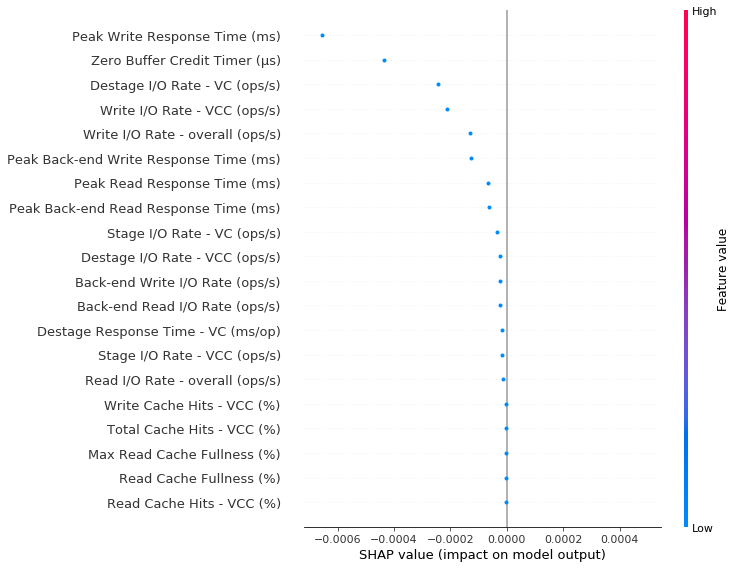

In [39]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=20)

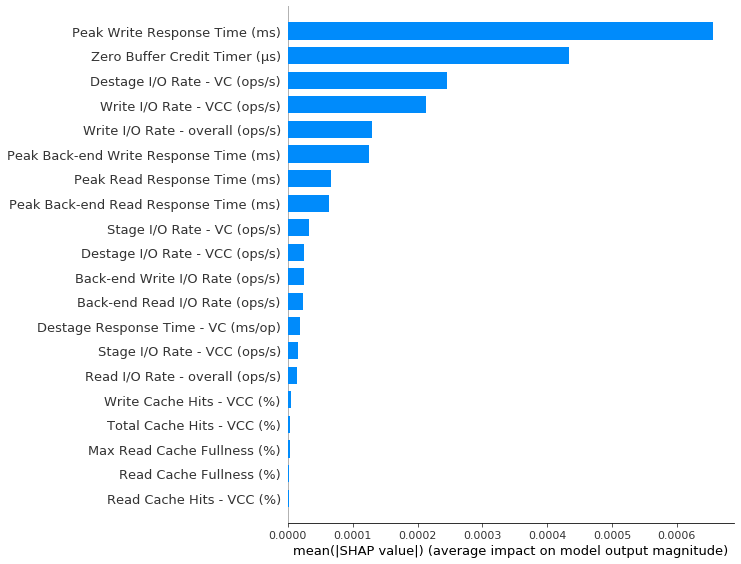

In [40]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=20, plot_type='bar')

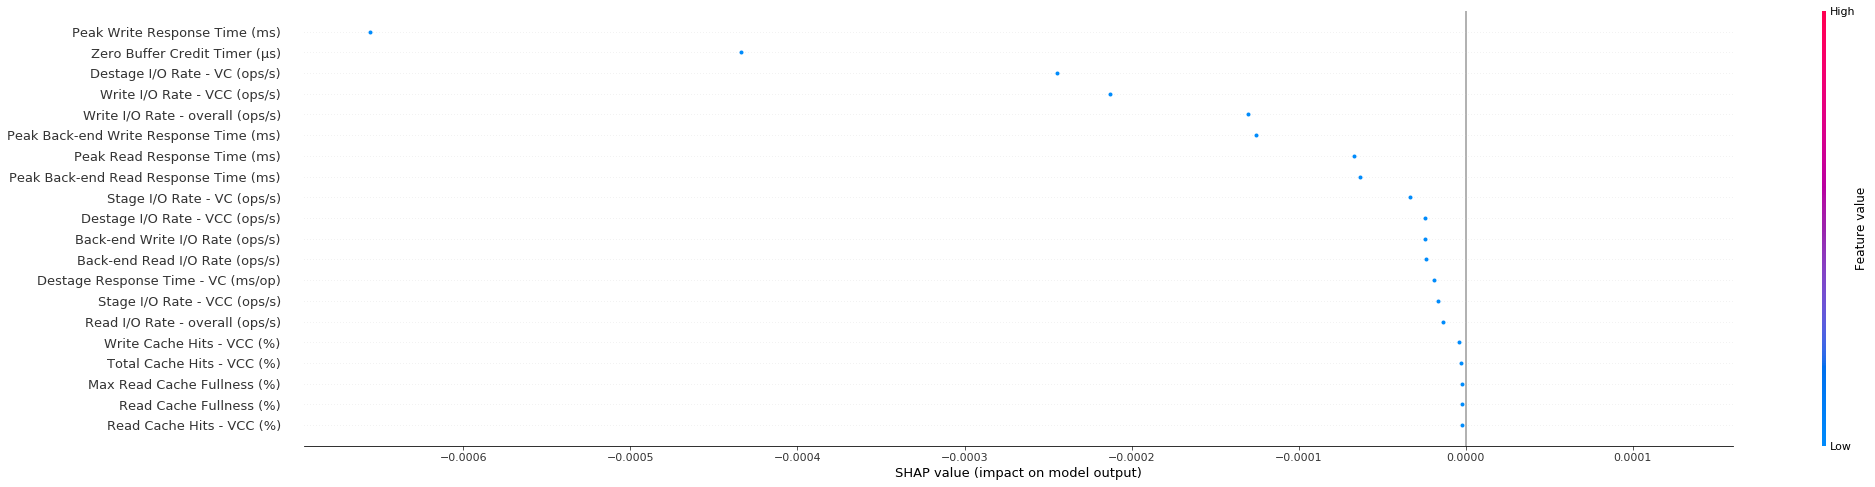

In [42]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=20,show=False,plot_size=(32,8))
plt.savefig('scratch.png',dpi=200)

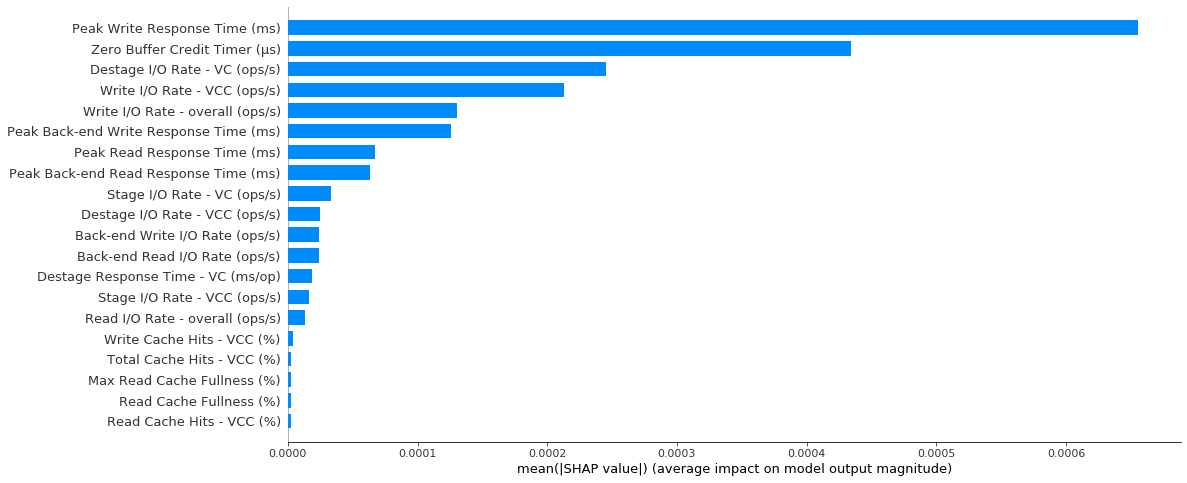

In [43]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=20,plot_type='bar',show=False,plot_size=(16,8) )
plt.savefig('scratch_2.png',dpi=200)

## Cluster Plot Top 50

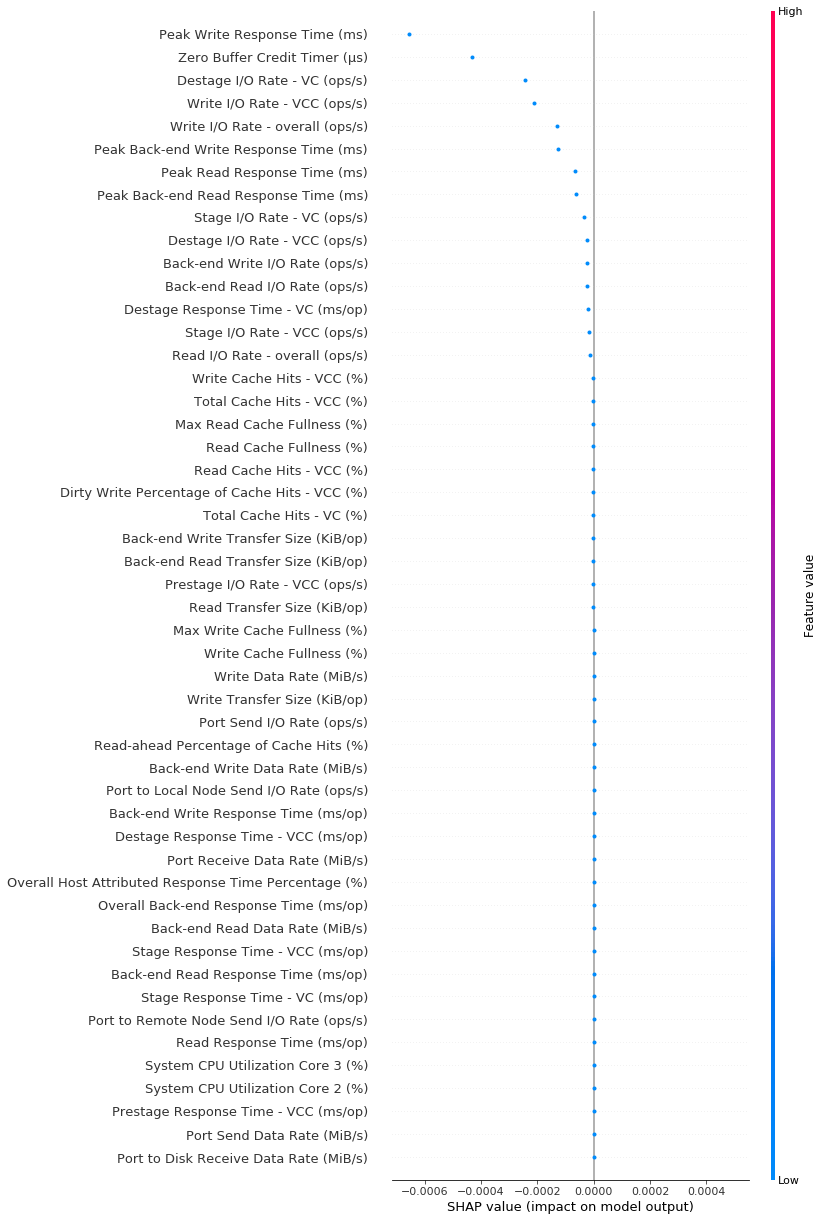

In [44]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=50)

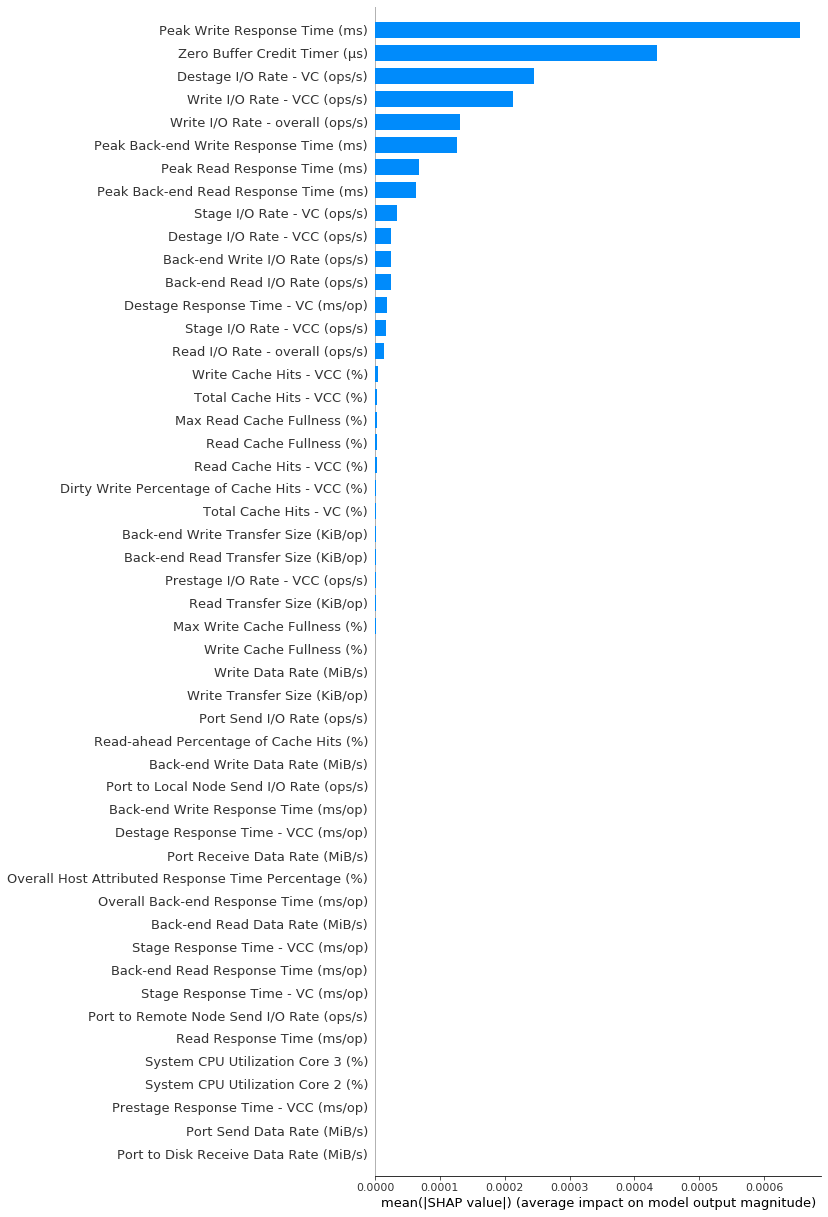

In [45]:
shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=50, plot_type='bar')

## Check Top5 Features per Sample

In [46]:
i_o_rates = []
for feature in features_order_in_data:
    if 'I/O' in feature:
        i_o_rates.append(feature)

response_rates = []
for feature in features_order_in_data:
    if 'Response' in feature:
        response_rates.append(feature)

In [47]:
cluster_indices_to_cluster_data

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [48]:
def get_reponse_time_samples(cluster_indices, shap_values, features, i_o_rates, response_rates, _print=False):
    reponse_time_samples = []
    for i in cluster_indices:
        #print("Sample", i)
        vals = shap_values_sample = shap_values[i].reshape(1, shap_values.shape[1])
        feature_importance = pd.DataFrame(list(zip(features, sum(vals))), columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=True,inplace=True)
        top_x = 5
        top = feature_importance.head(top_x)
        top_features = top.col_name
        if _print:
            print(top_features)
            print("")
        top_features = top_features.tolist()
        io = any(item in i_o_rates for item in top_features)
        response = any(item in response_rates for item in top_features)
        if response:
            print(top)
            print("Sample",i,":Response Time in Top" + str(top_x) + "Feature Importance")
            reponse_time_samples.append(i)
#        if io and response:
#            print("Sample",i,":IO Rate in Top" + str(top_x) + "Feature Importance")
    print(len(reponse_time_samples))
    return reponse_time_samples

In [49]:
get_reponse_time_samples(cluster_indices_to_cluster_data, shap_values_allTimesteps, features_order_in_data, i_o_rates, response_rates)

                            col_name  feature_importance_vals
43     Zero Buffer Credit Timer (µs)            -3.535433e-04
7   Write I/O Rate - overall (ops/s)            -5.070470e-06
59      Write I/O Rate - VCC (ops/s)            -2.299270e-06
60     Destage I/O Rate - VC (ops/s)            -1.165842e-06
38      Peak Read Response Time (ms)            -8.575153e-07
Sample 2 :Response Time in Top5Feature Importance
                                  col_name  feature_importance_vals
39           Peak Write Response Time (ms)                -0.001142
43           Zero Buffer Credit Timer (µs)                -0.000584
60           Destage I/O Rate - VC (ops/s)                -0.000414
59            Write I/O Rate - VCC (ops/s)                -0.000347
42  Peak Back-end Write Response Time (ms)                -0.000223
Sample 4 :Response Time in Top5Feature Importance
                                  col_name  feature_importance_vals
39           Peak Write Response Time (ms)          

[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

# Temporal Explanations

In [50]:
shap_values_allFeatures = numpy.nanmean(shap_values, axis=1)
print(shap_values_allFeatures.shape)
print(shap_values_allFeatures)

(14, 1113)
[[ 4.18143234e-07 -5.04780976e-06 -1.19601945e-07 ...             nan
              nan             nan]
 [ 3.92382001e-07 -6.38332968e-06 -8.81651901e-07 ...             nan
              nan             nan]
 [ 3.95088558e-07 -6.63903410e-06 -6.85190373e-07 ...             nan
              nan             nan]
 ...
 [ 4.06155460e-07 -5.52480727e-06 -5.88619079e-07 ...             nan
              nan             nan]
 [ 4.18004881e-07  1.04199689e-06  5.30083157e-07 ...             nan
              nan             nan]
 [-5.11890436e-06 -5.27700067e-06 -2.59654611e-06 ...             nan
              nan             nan]]


Mean of empty slice


## Categories

### Own Categories

In [51]:
def get_position_category_features(category_features, all_features_list):
    indices = []
    for feature in category_features:
        indices.append(all_features_list.index(feature))
    print(len(indices), indices)
    return indices

In [52]:
def get_samples_per_featureCategory(category_positions, dataset):
    category_data = []
    for x in dataset:
        anomaly = []
        for i in category_positions:
            anomaly.append(x[i])
        category_data.append(anomaly)
    category_data = numpy.array(category_data)
    print(category_data.shape)
    # average over features
    category_data = numpy.nanmean(category_data, axis=1)
    print(category_data.shape)
    return category_data

### SME Categories

In [53]:
categories = pd.read_csv("grafana_tags.csv")
print(categories['entity'].unique())
print(categories['tag'].unique())

['StorageSystem' 'StoragePorts' 'Nodes' 'ManagedDisks' 'Volumes']
['Response Time Essential' 'Cause' 'Impact' 'Response Time Advanced'
 'Workload Basic' 'Front-end Basic']


In [54]:
impact = categories.loc[categories['tag'] == 'Impact']
impact = impact['metric'].tolist()
# check which of those features are in our feature list
impact = [i for i in impact if i in features_order_in_data]
impact

['Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port to Local Node Send Response Time (ms/op)',
 'Port to Local Node Send Queue Time (ms/op)',
 'Port Send Delay I/O Percentage (%)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Write Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)']

In [55]:
cause = categories.loc[categories['tag'] == 'Cause']
cause = cause['metric'].tolist()
cause = [i for i in cause if i in features_order_in_data]
cause

['Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Write Data Rate (MiB/s)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Peak Read Response Time (ms)',
 'Peak Write Response Time (ms)',
 'Back-end Read I/O Rate (ops/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Back-end Read Data Rate (MiB/s)',
 'Back-end Write Data Rate (MiB/s)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Peak Back-end Read Response Time (ms)',
 'Peak Back-end Write Response Time (ms)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Write Data Rate (MiB/s)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Peak Read Response Time (ms)',
 'Peak Write Response Time (ms)']

In [56]:
workload_basic = categories.loc[categories['tag'] == 'Workload Basic']
workload_basic = workload_basic['metric'].tolist()
workload_basic = [i for i in workload_basic if i in features_order_in_data]
workload_basic

['Back-end Read Data Rate (MiB/s)',
 'Back-end Read I/O Rate (ops/s)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Write Data Rate (MiB/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Back-end Write Response Time (ms/op)']

In [57]:
frontend_basic = categories.loc[categories['tag'] == 'Front-end Basic']
frontend_basic = frontend_basic['metric'].tolist()
frontend_basic = [i for i in frontend_basic if i in features_order_in_data]
frontend_basic

['Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Read I/O Rate - overall (ops/s)',
 'Read Response Time (ms/op)',
 'Write Data Rate (MiB/s)',
 'Write I/O Rate - overall (ops/s)',
 'Write Response Time (ms/op)']

In [58]:
response_time_1 = categories.loc[categories['tag'] == 'Response Time Essential']
response_time_1 = response_time_1['metric'].tolist()
response_time_2 = categories.loc[categories['tag'] == 'Response Time Advanced']
response_time_2 = response_time_2['metric'].tolist()
response_time = response_time_1 + response_time_2
response_time = [i for i in response_time if i in features_order_in_data]
response_time

['Overall Host Attributed Response Time Percentage (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Write Response Time (ms/op)',
 'Port to Local Node Send Response Time (ms/op)',
 'Port to Local Node Receive Response Time (ms/op)',
 'Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Stage Response Time - VC (ms/op)',
 'Stage Response Time - VCC (ms/op)',
 'Prestage Response Time - VCC (ms/op)',
 'Cache to Host Transfer Response Time (ms/op)']

In [59]:
# features not belonging to any of the above categories
category_features = impact + cause + workload_basic + frontend_basic + response_time
print(len(category_features))
other = [i for i in features_order_in_data if i not in category_features]
print(len(other))
print(len(features_order_in_data))

59
52
84


## Averaged over Feature categories: IO Rates, Response Time, Cache, Data Rates, Transfer, Others

In [60]:
position_impact = get_position_category_features(impact, features_order_in_data)

positions_cause = get_position_category_features(cause, features_order_in_data)

positions_workload_basic = get_position_category_features(workload_basic, features_order_in_data)

positions_frontend_basic = get_position_category_features(frontend_basic, features_order_in_data)

positions_response_time = get_position_category_features(response_time, features_order_in_data)

positions_other = get_position_category_features(other, features_order_in_data)

11 [12, 13, 30, 32, 78, 77, 83, 2, 3, 12, 13]
22 [6, 7, 10, 16, 17, 38, 39, 33, 44, 55, 66, 4, 5, 8, 42, 6, 7, 10, 16, 17, 38, 39]
6 [55, 33, 77, 66, 44, 83]
7 [65, 67, 6, 12, 10, 7, 13]
13 [41, 12, 13, 77, 83, 30, 31, 65, 67, 68, 69, 70, 71]
52 [0, 1, 9, 11, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 34, 35, 36, 37, 40, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 72, 73, 74, 75, 76, 79, 80, 81, 82]


In [61]:
impact_data = get_samples_per_featureCategory(position_impact, dataset)

cause_data = get_samples_per_featureCategory(positions_cause, dataset)

workload_basic_data = get_samples_per_featureCategory(positions_workload_basic, dataset)

frontend_basic_data = get_samples_per_featureCategory(positions_frontend_basic, dataset)

response_time_data = get_samples_per_featureCategory(positions_response_time, dataset)

other_data = get_samples_per_featureCategory(positions_other, dataset)

(14, 11, 1113)
(14, 1113)
(14, 22, 1113)
(14, 1113)
(14, 6, 1113)
(14, 1113)
(14, 7, 1113)
(14, 1113)
(14, 13, 1113)
(14, 1113)
(14, 52, 1113)
(14, 1113)


Mean of empty slice


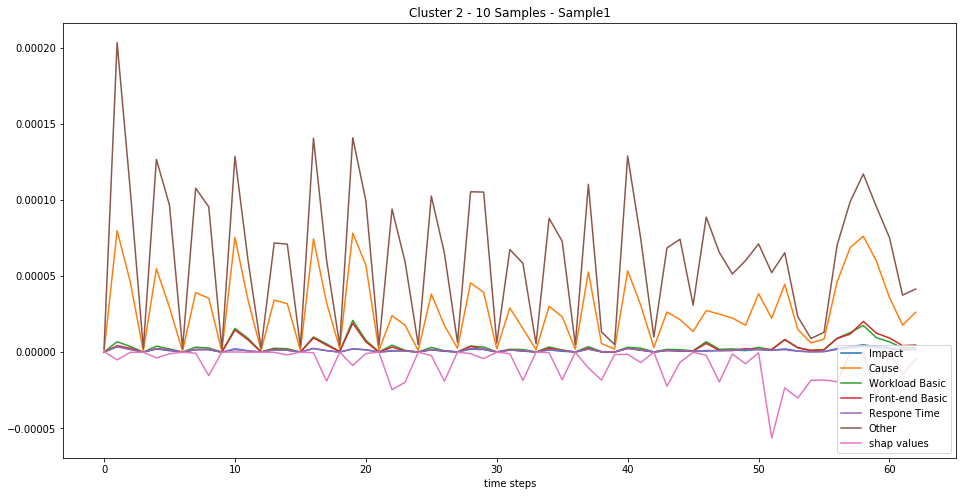

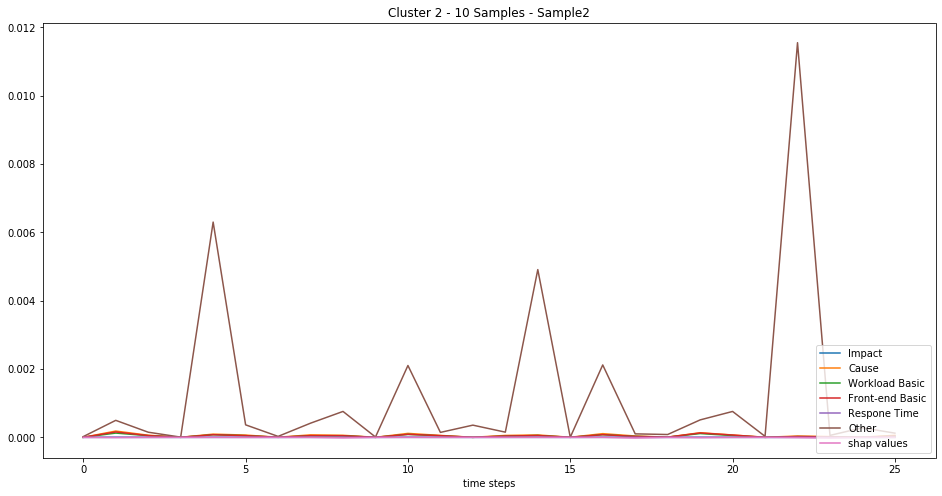

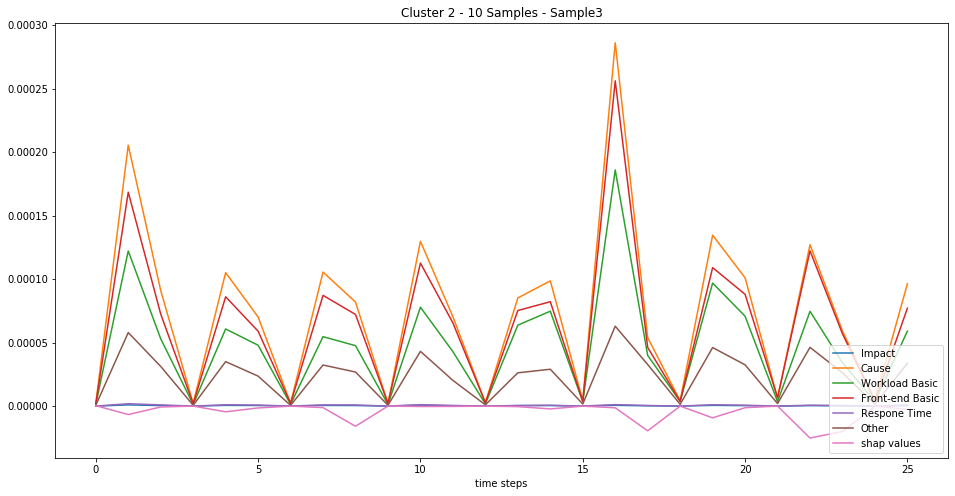

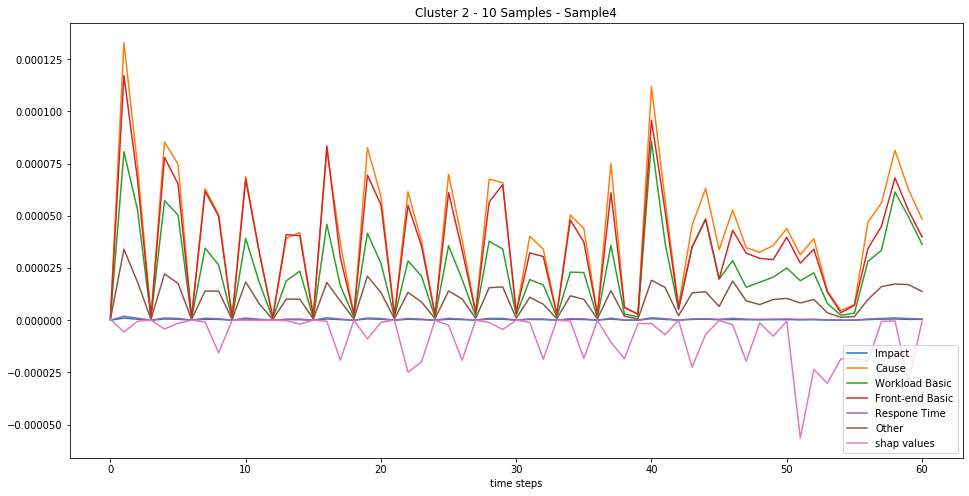

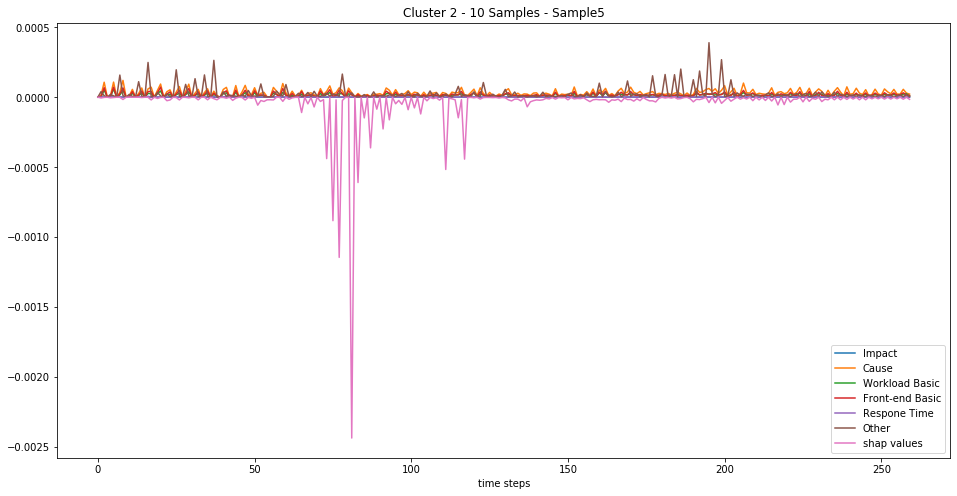

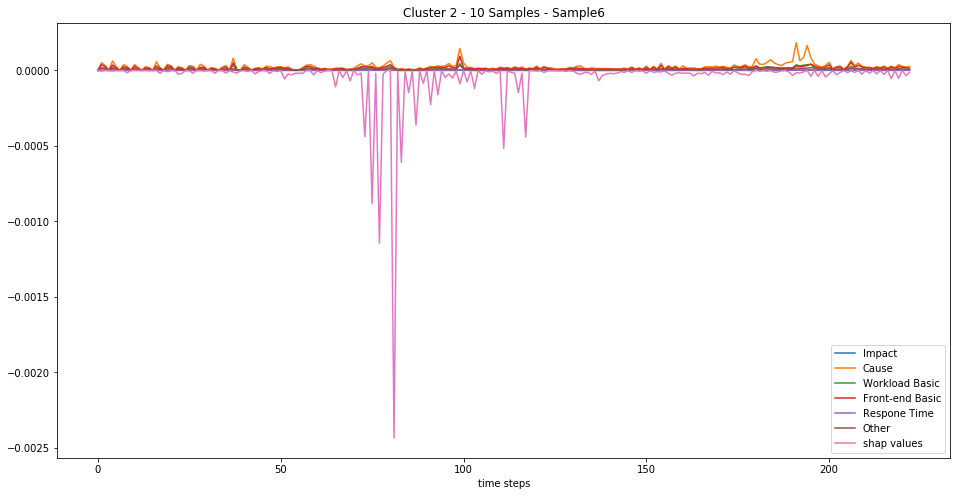

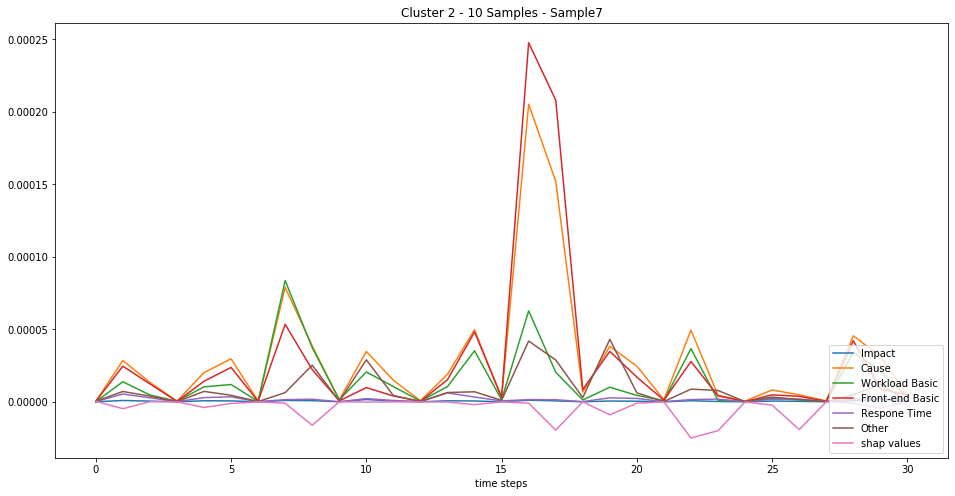

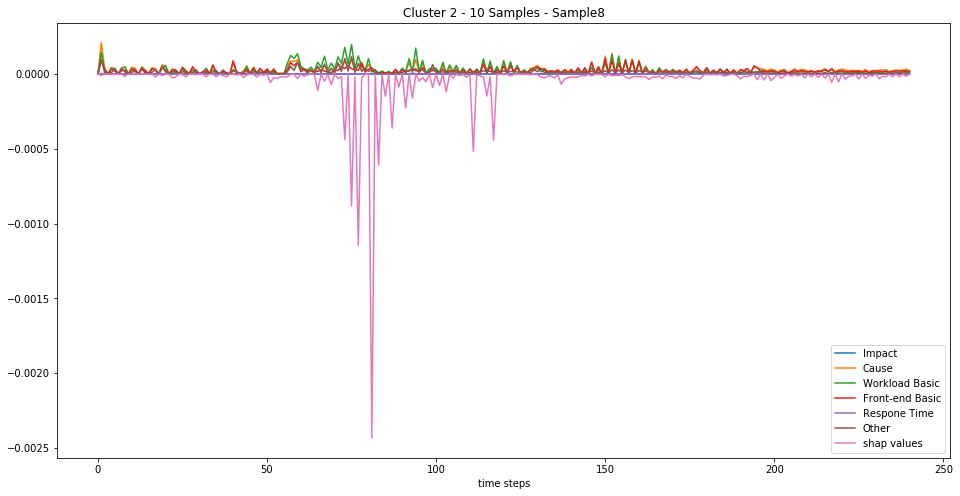

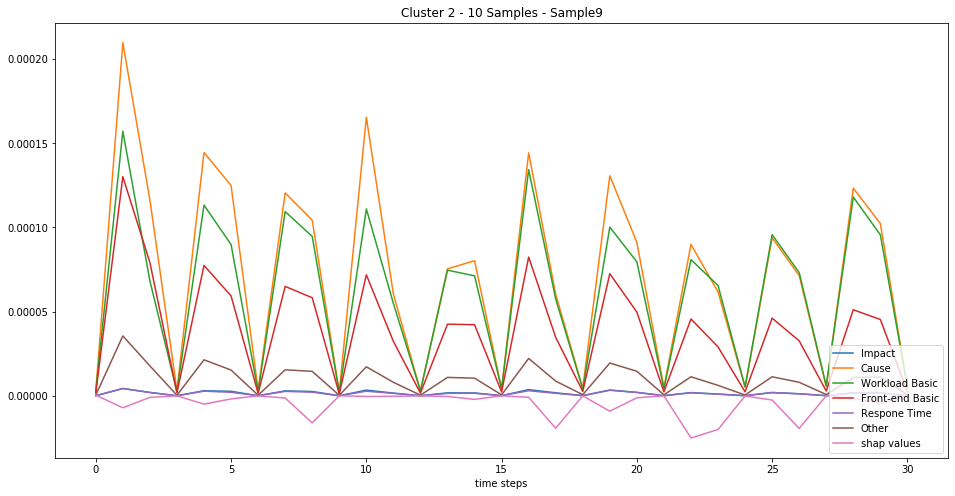

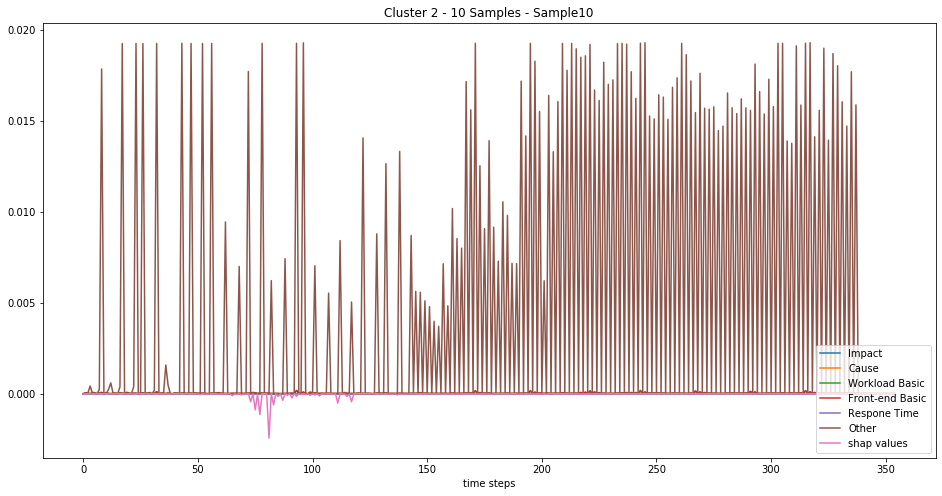

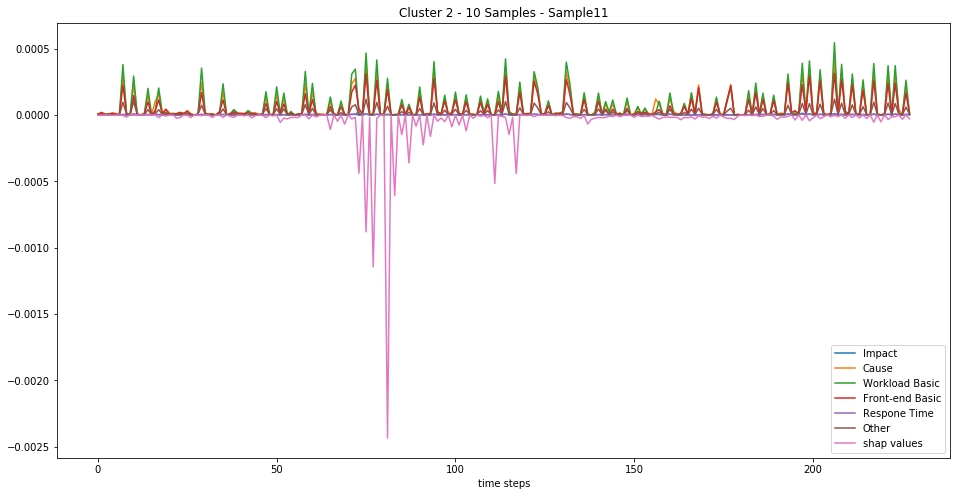

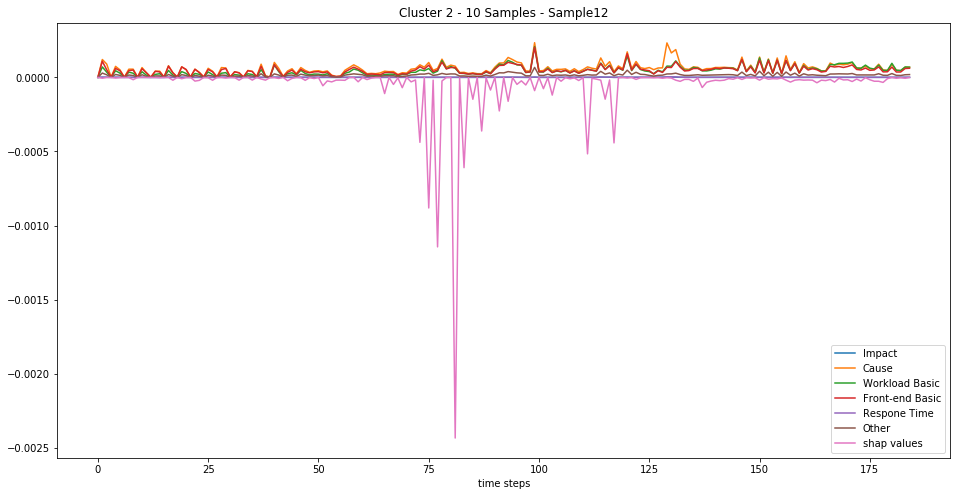

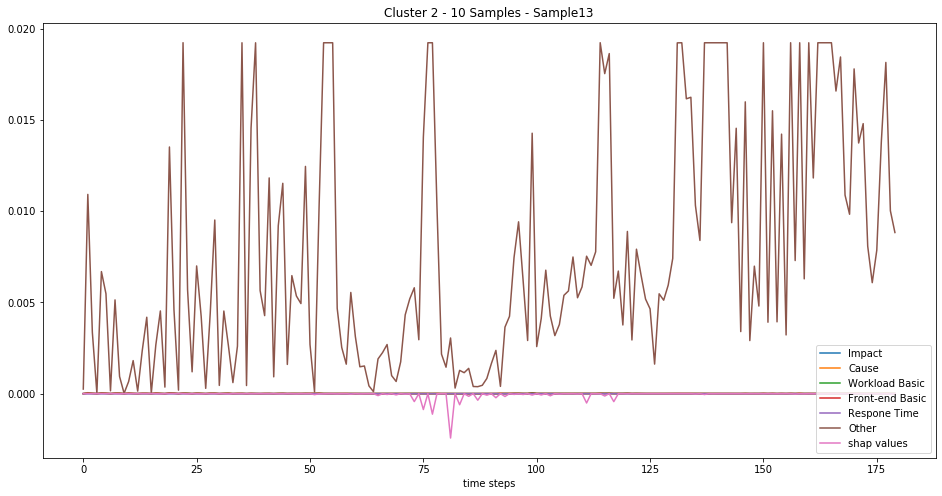

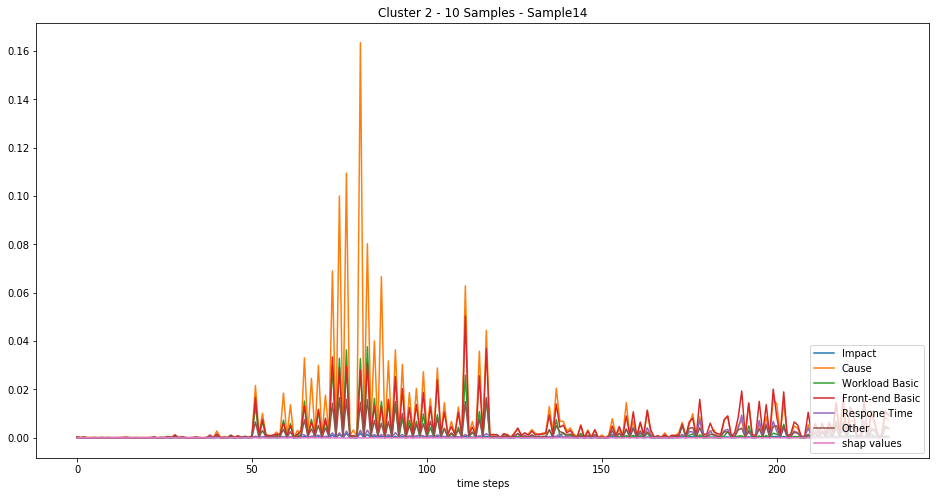

In [62]:
for i in range(0,14):
    plt.figure(figsize=(16,8))
    
    plt.plot(impact_data[i],label="Impact")
    
    plt.plot(cause_data[i],label="Cause")
    
    plt.plot(workload_basic_data[i],label="Workload Basic")
    
    plt.plot(frontend_basic_data[i],label="Front-end Basic")
    
    plt.plot(response_time_data[i],label="Respone Time")
    
    plt.plot(other_data[i],label="Other")
    
    plt.plot(shap_values_allFeatures[i],label="shap values")
    
    plt.xlabel("time steps")
    
    plt.legend(loc="lower right")
    
    plt.title("Cluster 2 - 10 Samples - Sample"+str(i+1))
    
    plt.savefig('/home/sto/Plots/temporal_explanations_may03/cluster_2_responseTime/cluster-2_responeTime_14-samples_sample-' + str(i+1) + '.png')

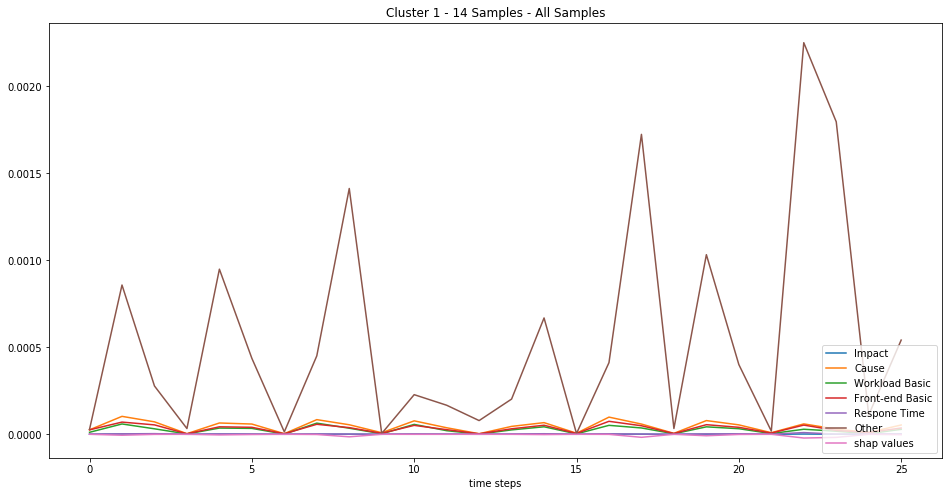

In [63]:
plt.figure(figsize=(16,8))
plt.plot(impact_data.mean(0),label="Impact")
plt.plot(cause_data.mean(0),label="Cause")
plt.plot(workload_basic_data.mean(0),label="Workload Basic")
plt.plot(frontend_basic_data.mean(0),label="Front-end Basic")
plt.plot(response_time_data.mean(0),label="Respone Time")
plt.plot(other_data.mean(0),label="Other")
plt.plot(shap_values_allFeatures.mean(0),label="shap values")
plt.xlabel("time steps")
plt.legend(loc="lower right")
plt.title("Cluster 1 - 14 Samples - All Samples")
plt.savefig('/home/sto/Plots/temporal_explanations/cluster_2_responseTime/cluster-2_14-samples_all-samples.png')

In [63]:
shap_values_allFeatures.mean(0).shape

(1113,)